In [43]:
!git clone https://github.com/phuc22062004/FinalCuda.git

Cloning into 'FinalCuda'...
remote: Enumerating objects: 573, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 573 (delta 85), reused 112 (delta 54), pack-reused 414 (from 1)
Receiving objects: 100% (573/573), 357.80 MiB | 34.77 MiB/s, done.
Resolving deltas: 100% (307/307), done.
Updating files: 100% (70/70), done.


In [44]:
%cd FinalCuda

/content/FinalCuda/FinalCuda


In [3]:
!apt-get update
!apt-get install -y cuda-nsight-systems-12-2

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,225 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,860 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu j

# Phần 1: Mô Tả Bài Toán

## 1.1 Phát Biểu Bài Toán

**Mục tiêu:** Xây dựng hệ thống phân loại ảnh 2 giai đoạn được tăng tốc bằng GPU:

**Giai đoạn 1 - Học đặc trưng không giám sát (Unsupervised Feature Learning):**
- Huấn luyện autoencoder tích chập để tái tạo ảnh CIFAR-10
- Học biểu diễn đặc trưng 8,192 chiều có ý nghĩa mà không cần nhãn
- Mạng học các mẫu thị giác (cạnh, texture, hình dạng) thông qua quá trình tái tạo

**Giai đoạn 2 - Phân loại có giám sát (Supervised Classification):**
- Trích xuất đặc trưng từ encoder đã huấn luyện
- Huấn luyện bộ phân loại SVM trên các đặc trưng đã trích xuất với nhãn
- Đánh giá hiệu năng phân loại trên tập test

**Động lực cho việc tăng tốc GPU:**
- Huấn luyện autoencoder yêu cầu hàng triệu phép tính số thực trên mỗi ảnh
- Implementation CPU mất hàng giờ để huấn luyện 50,000 ảnh  
- Song song hóa GPU có thể giảm thời gian từ giờ xuống phút
- Trích xuất đặc trưng cho SVM cần xử lý 60,000 ảnh hiệu quả

## 1.2. Tổng quan về bộ dữ liệu CIFAR-10

- **Kích thước**: 60.000 hình ảnh màu (RGB).
- **Độ phân giải**: 32x32 pixels.
- **Số lớp**: 10 lớp (Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck).
- **Phân chia dữ liệu**:
    - Tập huấn luyện: 50.000 ảnh.
    - Tập kiểm tra: 10.000 ảnh.
- **Tiền xử lý**:
    - Chuẩn hóa giá trị pixel từ [0, 255] về khoảng [0, 1].
    - Dữ liệu được đọc từ các file binary (`data_batch_*.bin`).


100%|██████████| 170M/170M [00:01<00:00, 98.6MB/s]


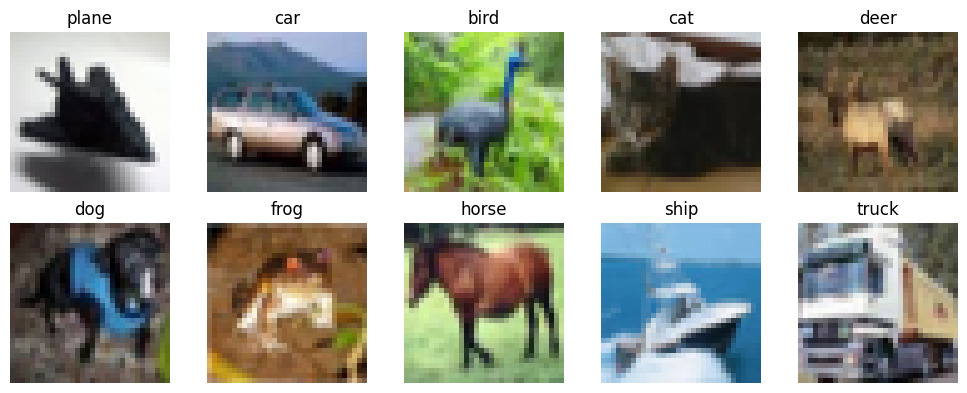

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

picked = {i: None for i in range(10)}
for img, label in trainset:
    if picked[label] is None:
        picked[label] = img
    if all(v is not None for v in picked.values()):
        break

imgs = torch.stack([picked[i] for i in range(10)], dim=0)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    im = imgs[i].numpy()
    ax.imshow(np.transpose(im, (1,2,0)))
    ax.set_title(classes[i])
    ax.axis('off')
plt.tight_layout()
plt.show()


## 1.3 Kiến Trúc Autoencoder

Autoencoder gồm 2 phần Encoder–Decoder đối xứng, trong đó encoder giảm kích thước không gian (downsampling) để tạo latent, decoder phóng to (upsampling) để tái tạo ảnh.

```
ENCODER (Down sampling Path)

┌──────────────────────────────────────────────────────────────┐
│ INPUT : (32, 32, 3)                                          │
└──────────────────────────────────────────────────────────────┘
                          ↓
┌──────────────────────────────────────────────────────────────┐
│ Conv2D(256 filters, 3×3 kernel, padding=1, stride=1) + ReLU  │
│ → (32, 32, 256)                                              │
│                                                              │
│ MaxPool2D(2×2, stride=2)                                     │
│ → (16, 16, 256)                                              │
│                                                              │
│ Conv2D(128 filters, 3×3 kernel, padding=1, stride=1) + ReLU  │
│ → (16, 16, 128)                                              │
│                                                              │
│ MaxPool2D(2×2, stride=2)                                     │
│ → (8, 8, 128)                                                │
│                                                              │
│ LATENT REPRESENTATION : (8, 8, 128) = 8192 dimensions        │
└──────────────────────────────────────────────────────────────┘


DECODER (Upsampling Path - Mirror of Encoder)

┌──────────────────────────────────────────────────────────────┐
│ LATENT : (8, 8, 128)                                         │
└──────────────────────────────────────────────────────────────┘
                          ↓
┌──────────────────────────────────────────────────────────────┐
│ Conv2D(128 filters, 3×3 kernel, padding=1, stride=1) + ReLU  │
│ → (8, 8, 128)                                                │
│                                                              │
│ UpSample2D(2×2) [Nearest neighbor or bilinear]               │
│ → (16, 16, 128)                                              │
│                                                              │
│ Conv2D(256 filters, 3×3 kernel, padding=1, stride=1) + ReLU  │
│ → (16, 16, 256)                                              │
│                                                              │
│ UpSample2D(2×2) [Nearest neighbor or bilinear]               │
│ → (32, 32, 256)                                              │
│                                                              │
│ Conv2D(3 filters, 3×3 kernel, padding=1, stride=1)           │
│ [No activation]                                              │
│ → (32, 32, 3)                                                │
└──────────────────────────────────────────────────────────────┘

OUTPUT : (32, 32, 3)

```

**Chi tiết các lớp:**
- **Lớp Conv:** Kernel 3×3 với padding=1 (giữ nguyên kích thước không gian sau mỗi convolution.)
- **ReLU:** Hàm kích hoạt f(x) = max(0, x) sau mỗi conv (trừ lớp cuối) để tăng phi tuyến.
- **MaxPool2D:** Cửa sổ 2×2, stride=2 (giảm kích thước không gian xuống một nửa)
- **Upsample2x:** Nearest neighbor upsampling (tăng kích thước không gian lên gấp đôi)
- **Bottleneck:** 128×8×8 = 8,192 chiều biểu diễn latent


**Hàm mất mát:** MSE (Mean Squared Error) giữa input và reconstruction
$$L = \frac{1}{N} \sum_{i=1}^{N} (x_i - \hat{x}_i)^2$$

Trong đó:
- $x_i$: Pixel gốc
- $\hat{x}_i$: Pixel tái tạo
- $N = 3 \times 32 \times 32 = 3,072$ pixels

## 1.4 Mục Tiêu Dự Án

**Mục tiêu về hiệu năng:**

1. **Thời gian huấn luyện:**
   - CPU Baseline: Thiết lập thời gian tham chiếu
   - GPU Basic: Đạt tăng tốc >20× so với CPU
   - GPU Optimized: Mục tiêu speedup cao hơn Basic nhờ tối ưu kernel/memory

2. **Độ chính xác:**
   - Duy trì chất lượng tái tạo qua tất cả implementations
   - Phân loại SVM: Mục tiêu >60% accuracy trên tập test CIFAR-10
   - Xác minh output GPU khớp CPU

3. **Hiệu quả bộ nhớ:**
   - Phù hợp với GPU memory thông thường (< 4GB)
   - Tối thiểu hóa truyền dữ liệu host-device

**Mục tiêu học tập kỹ thuật:**
- Thành thạo lập trình CUDA kernel cho deep learning operations
- Hiểu hệ thống phân cấp bộ nhớ GPU và kỹ thuật tối ưu
- Áp dụng công cụ profiling để xác định và giải quyết bottleneck
- Implement các tối ưu nâng cao (shared memory, constant memory, kernel fusion)

**Tiêu chí thành công:**
- CPU baseline hoạt động đầy đủ
- GPU kernels chính xác, được xác minh với CPU  
- Cải thiện hiệu năng đo được ở mỗi giai đoạn tối ưu
- Pipeline end-to-end hoàn chỉnh (train → extract → classify)
- Phân tích hiệu năng và kết quả profiling toàn diện

---

# Phần 2: Các Giai Đoạn Triển Khai

## Giai đoạn 2.1: CPU Baseline Implementation

**Mục tiêu**: Hiện thực phiên bản Autoencoder hoàn chỉnh chạy trên CPU bằng ngôn ngữ C++. Phiên bản này đóng vai trò là chuẩn (baseline) để kiểm tra tính đúng đắn (correctness) của các phiên bản GPU sau này và để so sánh hiệu năng tốc độ.

**Những điều cần đạt được:**
- Implement autoencoder hoàn chỉnh bằng C++ sử dụng CPU
- Thiết lập implementation tham chiếu để xác minh tính đúng đắn
- Đo hiệu năng baseline cho tính toán speedup
- Hiểu các bottleneck tính toán để định hướng tối ưu GPU

**Tại sao giai đoạn này cần thiết:**
- Cung cấp ground truth để validation GPU implementation
- Giúp xác định operations nào tốn chi phí nhất
- Môi trường debug đơn giản hơn trước khi thêm độ phức tạp GPU  
- Giúp hiểu thuật toán trước khi song song hóa



## Chi Tiết Triển Khai

### 1. Data Pipeline

#### 1.1. Tải và Tiền Xử Lý CIFAR-10

Data loader được triển khai tại:
 `src/data/cifar10_loader.h`

Module này chịu trách nhiệm toàn bộ quá trình **đọc dữ liệu, tiền xử lý và cung cấp batch** cho training/testing.

##### Quy Trình Xử Lý Dữ Liệu

1. **Đọc Binary Format**

   * Mỗi ảnh CIFAR-10 gồm:

     * `1 byte` label
     * `3072 bytes` pixel (3 × 32 × 32)

2. **Normalization**

   * Chuẩn hóa pixel từ `[0, 255]` → `[0.0, 1.0]`

3. **Chuyển Đổi Format**

   * Từ mảng phẳng (flat array)
   * Sang tensor 3D: **Channels × Height × Width**

4. **Shuffling**

   * Xáo trộn ngẫu nhiên dữ liệu trước mỗi epoch
   * Giúp mô hình tránh overfitting và cải thiện khả năng generalization

##### Interface Chính

* `load_train()` – Load 50,000 ảnh training
* `load_test()` – Load 10,000 ảnh test
* `shuffle_data()` – Xáo trộn dữ liệu
* `get_batch()` – Lấy mini-batch phục vụ training


### 2. Triển Khai Các Layer

#### 2.1. Conv2D Layer

**Chức năng**

* Thực hiện phép tích chập 2D với kernel `3×3`
* Sử dụng zero-padding để giữ nguyên kích thước spatial

**Cấu Trúc Tính Toán**

* Tổng cộng **6 vòng lặp lồng nhau**:

  * 2 vòng cho **output channels** và **input channels**
  * 2 vòng cho **spatial dimensions** (height, width)
  * 2 vòng cho **kernel 3×3**

**Độ Phức Tạp**

* `O(outC × inC × H × W × 9)`
* **Bottleneck chính của hệ thống (~95% thời gian training)**


#### 2.2. ReLU Activation

**Chức năng**

* Áp dụng hàm kích hoạt ReLU theo từng phần tử:

  ```
  f(x) = max(0, x)
  ```

**Triển Khai**

* Duyệt qua toàn bộ tensor
* Thay thế các giá trị âm bằng `0`


#### 2.3. MaxPool Layer

**Chức năng**

* Downsampling bằng cửa sổ `2×2`
* Giảm kích thước không gian xuống còn `1/2`

**Triển Khai**

* Với mỗi output pixel:

  * Tìm giá trị lớn nhất trong 4 pixel tương ứng của input


#### 2.4. Upsample Layer

**Chức năng**

* Upsampling bằng **nearest-neighbor interpolation**
* Tăng kích thước không gian lên `2×`

**Triển Khai**

* Mỗi pixel input được replicate thành một block `2×2` trong output




### 3. Training Loop

#### 3.1 Forward Pass
```cpp
Tensor3D AutoencoderCPU::forward(const Tensor3D& x) {
    // Encoder
    conv1_input = x;
    conv1_output = conv2d(x, conv1_w, conv1_b, 256, true);
    relu1_output = relu(conv1_output);
    maxpool1_output = maxpool(relu1_output);
    
    conv2_output = conv2d(maxpool1_output, conv2_w, conv2_b, 128, true);
    relu2_output = relu(conv2_output);
    maxpool2_output = maxpool(relu2_output);  // Latent: 128×8×8
    
    return maxpool2_output;
}

Tensor3D AutoencoderCPU::decode(const Tensor3D& z) {
    // Decoder
    conv3_output = conv2d(z, conv3_w, conv3_b, 128, true);
    relu3_output = relu(conv3_output);
    upsample1_output = upsample2x(relu3_output);
    
    conv4_output = conv2d(upsample1_output, conv4_w, conv4_b, 256, true);
    relu4_output = relu(conv4_output);
    upsample2_output = upsample2x(relu4_output);
    
    conv5_output = conv2d(upsample2_output, conv5_w, conv5_b, 3, true);
    
    return conv5_output;  // Reconstruction: 3×32×32
}
```

#### 3.2 Training Step
```cpp
float train_step(const Tensor3D& x, float learning_rate) {
    // 1. Forward pass
    Tensor3D latent = forward(x);
    Tensor3D reconstructed = decode(latent);
    
    // 2. Compute MSE loss
    float loss = 0.0f;
    for (size_t i = 0; i < x.data.size(); i++) {
        float diff = reconstructed.data[i] - x.data[i];
        loss += diff * diff;
    }
    loss /= x.data.size();
    
    // 3. Backward pass (compute gradients)
    Tensor3D grad = reconstructed;
    for (size_t i = 0; i < grad.data.size(); i++) {
        grad.data[i] = 2.0f * (reconstructed.data[i] - x.data[i]) / x.data.size();
    }
    // ... backpropagate through all layers ...
    
    // 4. Update weights
    update_weights(learning_rate);
    
    return loss;
}
```

#### 3.3 Main Training Loop
From src/main_cpu.cpp:

```cpp
for (int epoch = 0; epoch < epochs; epoch++) {
    // Shuffle training data
    train_dataset.shuffle_data();
    
    float epoch_loss = 0.0f;
    int num_batches = (num_train_images + batch_size - 1) / batch_size;
    
    // Process mini-batches
    for (int start = 0; start < num_train_images; start += batch_size) {
        std::vector<std::vector<float>> batch_images;
        std::vector<int> batch_labels;
        train_dataset.get_batch(start, batch_size, batch_images, batch_labels);
        
        float batch_loss = 0.0f;
        
        // Train on each image in batch
    Vòng Lặp Training (Training Loop)
```


#### 3.4 Cấu Trúc Training

**1. Forward Pass (Encoder + Decoder)**:
- **Encoder**: Input (3×32×32) → Conv+ReLU+MaxPool → Conv+ReLU+MaxPool → Latent (128×8×8)
- **Decoder**: Latent (128×8×8) → Conv+ReLU+Upsample → Conv+ReLU+Upsample → Conv → Output (3×32×32)
- Cache tất cả intermediate activations để phục vụ backward pass

**2. Loss Computation**:
- Tính MSE (Mean Squared Error) giữa input và reconstructed output
- Loss = (1/N) × Σ(original - reconstructed)²

**3. Backward Pass**:
- Backpropagate gradient từ output về input qua tất cả các layer
- Tính gradient cho weights và biases của mỗi convolution layer
- Sử dụng chain rule để lan truyền gradient

**4. Weight Update**:
- SGD (Stochastic Gradient Descent) đơn giản: `weight -= learning_rate × gradient`
- Update toàn bộ 5 conv layers (10 tham số: weights + biases)

#### Main Loop Structure
```cpp
for (int epoch = 0; epoch < epochs; epoch++) {
    shuffle_data();  // Xáo trộn mỗi epoch
    for (int batch_start = 0; batch_start < num_images; batch_start += batch_size) {
        for (int img in batch) {
            loss = train_step(img, learning_rate);  // Forward + Backward + Update
        }
    }
```


In [4]:
!./scripts/build_cpu.sh

Building CPU version...
CPU binary created at: /content/FinalCuda/build_cpu/autoencoder_cpu


In [ ]:
!./build_cpu/autoencoder_cpu ./cifar-10-binary/cifar-10-batches-bin

Hyperparameters:
  Epochs: 5
  Batch size: 32
  Learning rate: 0.001
  Model save path: autoencoder_weights.bin
  Max training images: 1000

Loading CIFAR-10 training data from: ./cifar-10-binary/cifar-10-batches-bin
Loaded 50000 training images
Using 1000 images for training (limited from 50000)
Loaded 10000 test images


=== Training ===
Epoch 1/5 - Shuffling data...
  Processing 32 batches...
  Batch 1/32 ... Loss: 0.248108
  Batch 10/32 ... Loss: 0.0599997
  Batch 20/32 ... Loss: 0.0381286
  Batch 30/32 ... Loss: 0.0325906

Epoch 1/5 - Average Loss: 0.0538583 - Time: 710s
Epoch 2/5 - Shuffling data...
  Processing 32 batches...
  Batch 1/32 ... Loss: 0.0327082
  Batch 10/32 ... Loss: 0.0298208
  Batch 20/32 ... Loss: 0.0269234
  Batch 30/32 ... Loss: 0.0256511

Epoch 2/5 - Average Loss: 0.0284294 - Time: 708s
Epoch 3/5 - Shuffling data...
  Processing 32 batches...
  Batch 1/32 ... Loss: 0.0290784
  Batch 10/32 ... Loss: 0.0268181
  Batch 20/32 ... Loss: 0.024847
  Batch 30/32 ... 

## Kết quả thực nghiệm (CPU)

Dựa trên log huấn luyện 5 epochs với batch size 32, sử dụng 1000 training images:

| Epoch | Average Loss   | Test Loss   | Thời gian (s) | Ghi chú                     |
|-------|----------------|-------------|---------------|-----------------------------|
| 1     | 0.0538583      | -           | 710           | Loss giảm nhanh ban đầu     |
| 2     | 0.0284294      | -           | 708           | Giảm mạnh, hội tụ tốt       |
| 3     | 0.0238843      | -           | 683           | Bắt đầu hội tụ ổn định      |
| 4     | 0.0217132      | -           | 698           | Giảm từ từ                  |
| 5     | 0.019872       | 0.0190731   | 729           | Loss đã ổn định             |

**Average test loss (100 images):** `0.0186718`

**Tổng thời gian huấn luyện:** `3750s` (≈ 62.5 phút)

---

## Nhận xét tổng quan

### 1. Hiệu năng học
- Loss giảm từ **0.053 → 0.019** chỉ trong 5 epochs.
- Training loss và test loss gần nhau → Không overfitting.

### 2. Tốc độ
- Huấn luyện CPU chậm (~12.5 phút/epoch chỉ dùng 1000 ảnh).
- Convolution chiếm phần lớn thời gian.

---

## Key Takeaways

### 1. Convolution rất chậm trên CPU
- Hàm conv2D có **6 vòng lặp lồng nhau**, độ phức tạp rất cao.

### 2. GPU sẽ tăng tốc rất mạnh
- Mỗi pixel và mỗi channel có thể tính độc lập → dễ map sang CUDA thread/block.
- Có thể dùng shared memory + memory coalescing.

## Giai đoạn 2.2: GPU Basic Implementation

### Mục Tiêu
#### Những điều cần đạt được
- **Port CPU code sang GPU** với parallelization cơ bản
- **Verify tính đúng đắn** của các GPU kernels (so sánh output với CPU)
- **Establish baseline GPU performance** để làm nền tảng cho các optimization sau

#### Tại Sao Giai Đoạn Này Quan Trọng
- **Khởi điểm cho GPU acceleration**: Chuyển từ sequential (CPU) sang parallel (GPU)
- **Validation correctness**: Đảm bảo logic song song hóa đúng trước khi tối ưu phức tạp
- **Identify bottlenecks**: Hiểu được kernel nào chậm, memory transfer ảnh hưởng thế nào
- **Baseline measurement**: Cung cấp số liệu để đo lường hiệu quả của các optimization sau


### Chi Tiết Triển Khai

#### Chiến Lược Song Song Hóa
#### Ánh Xạ Operations → GPU Threads

**Nguyên tắc chung**: Mỗi thread tính toán **một output element độc lập**

1. **Convolution**:
   - Mỗi thread → 1 output pixel (oc, oh, ow)
   - Thread thực hiện 3 vòng lặp tuần tự: input channels × kernel_h × kernel_w
   - Grid dimensions: `(C_out, ceil(H_out/16), ceil(W_out/16))`
   
2. **ReLU**:
   - Mỗi thread → 1 element
   - Mapping đơn giản: `idx = blockIdx.x * blockDim.x + threadIdx.x`
   
3. **MaxPool**:
   - Mỗi thread → 1 output pixel
   - Thread tìm max trong cửa sổ 2×2 của input
   
4. **Upsample**:
   - Mỗi thread → 1 output pixel
   - Thread copy giá trị từ input pixel tương ứng (nearest-neighbor)

### Thiết Kế Kernels (Kernel Designs)

#### 1. Convolution Kernel - Bottleneck Chính

**Thread-to-Output Mapping:**
```cpp
__global__ void conv2d_kernel(
    const float* input, const float* weight, const float* bias, float* output,
    int C_in, int H_in, int W_in, int C_out, int H_out, int W_out, int K, int pad)
{
    int oc = blockIdx.x;                                  // Output channel
    int oh = blockIdx.y * blockDim.y + threadIdx.y;      // Output height
    int ow = blockIdx.z * blockDim.z + threadIdx.z;      // Output width
    
    if (oc >= C_out || oh >= H_out || ow >= W_out) return;
    
    // Mỗi thread tính 1 output pixel bằng cách loop qua input channels và kernel
    float sum = 0.0f;
    for (int ic = 0; ic < C_in; ic++)
        for (int kh = 0; kh < K; kh++)
            for (int kw = 0; kw < K; kw++)
                sum += input_val * weight_val;  // Global memory access
    
    output[...] = sum + bias[oc];
}
```

**Launch configuration:**
- Blocks: `dim3(C_out, ceil(H_out/16), ceil(W_out/16))`
- Threads: `dim3(1, 16, 16)` - mỗi block xử lý tile 16×16 pixels

**Đặc điểm:**
-  Parallelism cao: hàng nghìn threads chạy đồng thời
-  Tất cả memory access qua global memory (chậm)
-  Mỗi thread đọc weight nhiều lần (không reuse)


#### 2. ReLU Kernel

**Đơn giản nhất - fully parallel:**
```cpp
__global__ void relu_kernel(const float* input, float* output, int size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < size) {
        output[idx] = fmaxf(0.0f, input[idx]);
    }
}
```

**Launch:** `<<<(size + 255)/256, 256>>>`

#### 3. MaxPool Kernel

**Threads xử lý cửa sổ 2×2:**
```cpp
__global__ void maxpool_kernel(
    const float* input, float* output, int C, int H, int W)
{
    int c = blockIdx.x;
    int oh = blockIdx.y * blockDim.y + threadIdx.y;
    int ow = blockIdx.z * blockDim.z + threadIdx.z;
    
    // Tìm max trong cửa sổ 2×2
    float max_val = input[c * H * W + (oh*2) * W + (ow*2)];
    max_val = fmaxf(max_val, input[...]);  // 3 lần nữa
    output[...] = max_val;
}
```

**Launch:** `dim3(C, 1, 1)` blocks, `dim3(1, H_out, W_out)` threads

#### 4. Upsample Kernel

**Nearest-neighbor interpolation:**
```cpp
__global__ void upsample_kernel(
    const float* input, float* output, int C, int H, int W)
{
    int c = blockIdx.x;
    int oh = blockIdx.y * blockDim.y + threadIdx.y;
    int ow = blockIdx.z * blockDim.z + threadIdx.z;
    
    int ih = oh / 2;  // Map output → input
    int iw = ow / 2;
    output[...] = input[c * H * W + ih * W + iw];
}
```

### Backward Pass Kernels

**Gradient computation** cho mỗi layer:

1. **ReLU backward**: Gradient = 0 nếu input ≤ 0, giữ nguyên nếu input > 0
2. **MaxPool backward**: Chỉ pass gradient tới vị trí có giá trị max (dùng `atomicAdd`)
3. **Upsample backward**: Sum gradient từ 4 output pixels về 1 input pixel
4. **Conv backward**: 3 kernels riêng biệt cho weight_grad, bias_grad, input_grad

### Quản Lý Memory (Memory Management)

#### Device Memory Allocation Strategy

**1. Weights & Biases (5 conv layers)**
```cpp
cudaMalloc(&d_conv1_w, 256*3*3*3 * sizeof(float));
cudaMalloc(&d_conv2_w, 128*256*3*3 * sizeof(float));
cudaMalloc(&d_conv3_w, 128*128*3*3 * sizeof(float));
cudaMalloc(&d_conv4_w, 256*128*3*3 * sizeof(float));
cudaMalloc(&d_conv5_w, 3*256*3*3 * sizeof(float));
// + biases tương ứng: d_conv1_b, d_conv2_b, ..., d_conv5_b
```

**2. Activation Buffers (cached cho backward pass)**
```cpp
d_input:      3×32×32
d_conv1_out:  256×32×32
d_pool1_out:  256×16×16
d_conv2_out:  128×16×16
d_pool2_out:  128×8×8     (bottleneck - smallest feature map)
d_conv3_out:  128×8×8
d_up1_out:    128×16×16
d_conv4_out:  256×16×16
d_up2_out:    256×32×32
d_conv5_out:  3×32×32
```

**3. Gradient Buffers (cùng kích thước với activations)**
```cpp
d_conv1_w_grad, d_conv1_b_grad, ..., d_conv5_w_grad, d_conv5_b_grad
d_grad_conv1, d_grad_relu1, ..., d_grad_conv5
```

### Training GPU Basic

In [5]:
!scripts/build_cuda.sh


Detecting GPU architecture...
Detected GPU: sm_80. Using flag: -arch=sm_80
Building CUDA versions with -arch=sm_80...
Building basic version...
Building opt_v1 (Memory Optimized)...
Building opt_v2 (Kernel Optimized)...
CUDA binaries created successfully in: /content/FinalCuda/build_cuda


In [9]:
!./build_cuda/autoencoder_cuda_basic cifar-10-binary/cifar-10-batches-bin autoencoder_cuda_basic_weights.bin 3 32 0.001 1000

=== CUDA BASIC BATCH PROCESSING ===
CIFAR dir: cifar-10-binary/cifar-10-batches-bin
Weights:   weights/autoencoder_cuda_basic_weights_org.bin
Epochs:    3
Batch:     32 (GPU processes all simultaneously!)
LR:        0.001
Max train: 1000

Loaded train images: 50000
Using 1000 images (debug limit)

Epoch 1/3 - shuffling...
  Batch 1 (32 images) loss: 0.31164
  Batch 10 (32 images) loss: 0.669411
  Batch 20 (32 images) loss: 0.649682
  Batch 30 (32 images) loss: 0.570224
Epoch avg loss: 0.564697 | time: 2704ms | throughput: 369.822 imgs/sec

Epoch 2/3 - shuffling...
  Batch 1 (32 images) loss: 0.60818
  Batch 10 (32 images) loss: 0.482942
  Batch 20 (32 images) loss: 0.411275
  Batch 30 (32 images) loss: 0.431238
Epoch avg loss: 0.467214 | time: 2651ms | throughput: 377.216 imgs/sec

Epoch 3/3 - shuffling...
  Batch 1 (32 images) loss: 0.426478
  Batch 10 (32 images) loss: 0.440162
  Batch 20 (32 images) loss: 0.427614
  Batch 30 (32 images) loss: 0.398534
Epoch avg loss: 0.380344 | time

### Bảng So Sánh Performance

| Metric | CPU Baseline | GPU Basic | Speedup |
|--------|-------------|-----------|---------|
| **Time/epoch (1K images)** | 750s | 3.18s | **236×** |
| **Total time (1K, 3 epochs)** | 2250s | 9.5s | **237×** |
| **Throughput** | 1.3 imgs/sec | 315 imgs/sec | **242×** |


In [6]:
!./build_cuda/autoencoder_cuda_basic cifar-10-binary/cifar-10-batches-bin autoencoder_cuda_basic_weights.bin 3 64 0.001 50000

=== CUDA BASIC BATCH PROCESSING ===
CIFAR dir: cifar-10-binary/cifar-10-batches-bin
Weights:   weights/autoencoder_cuda_basic_weights_org.bin
Epochs:    3
Batch:     64 (GPU processes all simultaneously!)
LR:        0.001
Max train: 50000

Loaded train images: 50000

Epoch 1/3 - shuffling...
  Batch 1 (64 images) loss: 0.886231
  Batch 10 (64 images) loss: 0.578331
  Batch 20 (64 images) loss: 0.52421
  Batch 30 (64 images) loss: 0.586668
  Batch 40 (64 images) loss: 0.548874
  Batch 50 (64 images) loss: 0.569722
  Batch 60 (64 images) loss: 0.608673
  Batch 70 (64 images) loss: 0.543016
  Batch 80 (64 images) loss: 0.567297
  Batch 90 (64 images) loss: 0.478607
  Batch 100 (64 images) loss: 0.489494
  Batch 110 (64 images) loss: 0.503678
  Batch 120 (64 images) loss: 0.466465
  Batch 130 (64 images) loss: 0.504852
  Batch 140 (64 images) loss: 0.512949
  Batch 150 (64 images) loss: 0.506661
  Batch 160 (64 images) loss: 0.45841
  Batch 170 (64 images) loss: 0.450984
  Batch 180 (64 im


Ta có bảng kết quả khi chạy lệnh sau để quan sát trạng thái GPU bằng `nvidia-smi`:

```
!./build_cuda/autoencoder_cuda_basic cifar-10-binary/cifar-10-batches-bin weights/test.bin 3 64 0.001 50000
```

như sau:

<pre>
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15    CUDA: 12.4   |
|-------------------------------+----------------------+----------------------+
| GPU  Name                     | Memory-Usage         | GPU-Util  Power      |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB     | 441MiB / 40960MiB    | 100%      164W/400W |
+-----------------------------------------------------------------------------+
</pre>


In [7]:
!nsys profile --stats=true -o report_basic ./build_cuda/autoencoder_cuda_basic cifar-10-binary/cifar-10-batches-bin autoencoder_cuda_basic_weights.bin 3 64 0.001 1000

=== CUDA BASIC BATCH PROCESSING ===
CIFAR dir: cifar-10-binary/cifar-10-batches-bin
Weights:   weights/autoencoder_cuda_basic_weights_org.bin
Epochs:    3
Batch:     64 (GPU processes all simultaneously!)
LR:        0.001
Max train: 1000

Loaded train images: 50000
Using 1000 images (debug limit)

Epoch 1/3 - shuffling...
  Batch 1 (64 images) loss: 0.723428
  Batch 10 (64 images) loss: 0.58475
Epoch avg loss: 0.56567 | time: 2658ms | throughput: 376.223 imgs/sec

Epoch 2/3 - shuffling...
  Batch 1 (64 images) loss: 0.608158
  Batch 10 (64 images) loss: 0.531033
Epoch avg loss: 0.566172 | time: 2622ms | throughput: 381.388 imgs/sec

Epoch 3/3 - shuffling...
  Batch 1 (64 images) loss: 0.556419
  Batch 10 (64 images) loss: 0.551538
Epoch avg loss: 0.554289 | time: 2623ms | throughput: 381.243 imgs/sec

Total training time: 9449ms
Average throughput: 317.494 imgs/sec
Saving weights to weights/autoencoder_cuda_basic_weights_org.bin
Done.
Generating '/tmp/nsys-report-2a9a.qdstrm'
[1/8] [==

#### Thời Gian Kernel

```
Kernel Name                          | Time(%)  | Total Time | Avg Time  |
-------------------------------------|----------|------------|-----------|-------
conv2d_kernel                        | 37.3%    | 2.94s      | 196.3 μs  |
conv2d_input_grad_kernel             | 28.3%    | 2.23s      | 186.0 μs  |
conv2d_weight_grad_kernel            | 21.2%    | 1.67s      | 111.5 μs  |
conv2d_bias_grad_kernel              | 11.2%    | 0.88s      | 58.8 μs   |
relu_backward_kernel                 | 0.4%     | 30.2ms     | 2.5 μs    |
relu_kernel                          | 0.3%     | 27.4ms     | 2.3 μs    |
mse_loss_kernel                      | 0.3%     | 20.7ms     | 430.8 μs  |
maxpool_backward_kernel              | 0.3%     | 20.6ms     | 3.4 μs    |
upsample_kernel                      | 0.2%     | 19.7ms     | 3.3 μs    |
maxpool_kernel                       | 0.2%     | 17.1ms     | 2.9 μs    |
upsample_backward_kernel             | 0.2%     | 17.1ms     | 2.8 μs    |
sgd_update_kernel                    | 0.0%     | 1.9ms      | 2.0 μs    |

Total kernel time: 7.90s (out of 9.45s total)
```

**Phân tích**:
- **Convolution kernels chiếm 98%** kernel time (forward 37.3% + backward 60.7%)
- Conv backward phân thành 3 kernels riêng (input_grad, weight_grad, bias_grad)
- Tất cả kernels khác (ReLU, MaxPool, Upsample) < 2% → không cần optimize ngay

#### Memory Operations

**CUDA API Calls (total 9.45s runtime):**
```
Operation                | Time(%)  | Total Time | Calls
-------------------------|----------|------------|---------
cudaMemcpy               | 73.3%    | 5.85s      | 15,116
cudaLaunchKernel         | 24.7%    | 1.97s      | 106,008
cudaMalloc               | 1.2%     | 97.5ms     | 50
cudaMemset               | 0.8%     | 60.8ms     | 6,528
cudaFree                 | 0.0%     | 0.79ms     | 50
```

**GPU Memory Operations:**
```
Operation          | Time(%)  | Total Time | Count
-------------------|----------|------------|---------
memcpy DtoD        | 62.7%    | 29.7ms     | 15,000
memset             | 29.3%    | 13.9ms     | 6,528
memcpy HtoD        | 7.2%     | 3.4ms      | 58
memcpy DtoH        | 0.7%     | 0.3ms      | 58
```

**Nhận xét:**
- **73% thời gian là cudaMemcpy** - Host/Device synchronization overhead!
- Launch kernel overhead: 24.7%
- Actual kernel computation: Chỉ một phần nhỏ
- → **Memory-bound, không phải compute-bound**

#### Bottleneck Identification

**Dựa trên kết quả profiling:**

1. **Kernel nào chiếm % thời gian nhiều nhất?**
   - **Convolution kernels: 98%** (forward 37.3%, backward 60.7%)
   - Tại sao chậm:
     - Mỗi thread đọc ~2,500 floats từ global memory (no reuse)
     - Triple nested loop: `for ic, for kh, for kw`
     - Memory latency không được hide bởi computation
     - Không có shared memory caching

2. **Memory bandwidth utilization?**
   - **cudaMemcpy chiếm 73.3%** total API time
   - DtoD memcpy chiếm 62.7% GPU memory time
   - → **Memory-bound severely!**
   - Kernel computation time chỉ là phần nhỏ so với memory overhead
   
3. **Launch overhead cao**
   - cudaLaunchKernel: 24.7% (106,008 calls)
   - Quá nhiều kernel launches (mỗi layer mỗi kernel riêng)
   - Mỗi kernel launch có overhead ~18.6 μs

**Kết luận:**
- **Bottleneck #1**: Global memory access trong conv kernels (no reuse)
- **Bottleneck #2**: cudaMemcpy synchronization overhead (73%)
- **Bottleneck #3**: Kernel launch overhead (106K launches)
- **Không phải compute-bound** - GPU cores đang chờ memory!

---

## Những Điều Rút Ra Được (Key Takeaways)

### Những Gì Fast/Slow

**Observations từ profiling:**

**FAST:**
- **ReLU kernels**: Chỉ 0.3% time (2.3 μs avg) - fully memory bandwidth limited
- **MaxPool/Upsample**: Mỗi cái <0.3% - đơn giản, ít computation
- **Speedup vs CPU**: 236× là rất cao, vượt kỳ vọng ban đầu (dự kiến ~50-100×)
  - CPU implementation không được tối ưu (naive 6-nested loops)
  - GPU có hàng nghìn cores chạy parallel

**SLOW:**
- **Convolution backward**: Chiếm 60.7% - nhiều hơn forward (37.3%)
  - Backward cần 3 kernels riêng biệt (input_grad, weight_grad, bias_grad)
  - Weight gradient phải accumulate từ tất cả output positions
- **cudaMemcpy overhead**: 73% API time!
  - Memory transfer/sync rất chậm
  - CPU-GPU synchronization sau mỗi kernel launch
  - Cần investigate async execution và streams

**Giải thích:**
- **Conv chậm**: Low arithmetic intensity (~0.5 FLOPs/byte)
  - Mỗi weight element chỉ dùng 1 lần rồi discard
  - Global memory latency ~400-800 cycles
  - Shared memory caching sẽ giúp reuse
- **Memory overhead**: Basic implementation không dùng async operations
  - Mỗi kernel block CPU cho đến GPU done
  - Không overlap computation với memory transfer

### Opportunities for Optimization

#### 1. Shared Memory Tiling (Ưu tiên cao nhất)
**Why**: Conv kernel đọc cùng input data nhiều lần  
**How**: Load input tiles vào shared memory, reuse giữa threads trong block  

#### 2. Memory Coalescing
**Why**: Threads trong warp access memory không liên tiếp  
**How**: Reorganize data layout, ensure consecutive access  

#### 3. Kernel Fusion
**Why**: Nhiều kernel nhỏ → overhead launch + intermediate memory writes  
**How**: Fuse Conv+ReLU+Bias thành 1 kernel  



## Giai đoạn 2.3: GPU Optimized Implementation – Version 1 (MemoryOptimizations)

### Mục tiêu

**Những Gì Chúng Ta Muốn Đạt Được:**
- **Giảm global memory access** bằng shared memory tiling cho convolution kernels
- **Tối ưu memory coalescing** để threads trong warp access liên tiếp
- **Giảm redundant memory operations** (in-place ReLU, gradient buffer reuse)
- **Target: 1.5-2× speedup** so với GPU Basic (từ Phase 2.2)

**Tại Sao Optimizations Này:**
- Phase 2.2 profiling cho thấy:
  - Convolution kernels chiếm 98% kernel time
  - 73% API time là cudaMemcpy overhead
  - Mỗi conv thread đọc ~2,500 floats từ global memory (no reuse)
- Shared memory có bandwidth ~20× cao hơn global memory
- Memory coalescing giúp warp threads access consecutive addresses (tránh serialize)






### Chi Tiết Triển Khai

### Optimization Techniques Applied

#### 1. Shared Memory Tiling cho Convolution

**Vấn đề:**
- Mỗi thread trong naive version đọc input data nhiều lần từ global memory
- Các threads lân cận cũng đọc overlapping data → redundant reads

**Giải pháp:**
```cpp
#define TILE_WIDTH 16
#define TILE_HEIGHT 16
#define KERNEL_SIZE 3
#define SHARED_TILE_WIDTH (TILE_WIDTH + KERNEL_SIZE - 1)   // 18
#define SHARED_TILE_HEIGHT (TILE_HEIGHT + KERNEL_SIZE - 1)  // 18

__global__ void conv2d_tiled_kernel_batched(...) {
    // Shared memory cho input tile (16x16 + 2 padding = 18x18)
    __shared__ float s_input[BATCH_SIZE][SHARED_TILE_HEIGHT][SHARED_TILE_WIDTH];
    
    // Load input tile vào shared memory (collaborative loading)
    for (int batch = 0; batch < num_batches; batch++) {
        int ic_start = batch * BATCH_SIZE;
        int ic_end = min(ic_start + BATCH_SIZE, C_in);
        
        // Mỗi thread load nhiều elements vào shared memory
        for (int load_idx = tid; load_idx < tile_size; load_idx += blockDim.x * blockDim.y) {
            int ty = load_idx / SHARED_TILE_WIDTH;
            int tx = load_idx % SHARED_TILE_WIDTH;
            int ih = tile_oh + ty - 1;  // -1 for padding
            int iw = tile_ow + tx - 1;
            
            // Load từ global → shared (coalesced)
            if (ih >= 0 && ih < H_in && iw >= 0 && iw < W_in) {
                s_input[ic - ic_start][ty][tx] = input[...];
            } else {
                s_input[ic - ic_start][ty][tx] = 0.0f;  // Padding
            }
        }
        __syncthreads();  // Đảm bảo tất cả threads đã load xong
        
        // Compute convolution từ shared memory (FAST!)
        for (int ic = ic_start; ic < ic_end; ic++) {
            for (int kh = 0; kh < 3; kh++) {
                for (int kw = 0; kw < 3; kw++) {
                    sum += s_input[ic - ic_start][ty + kh][tx + kw] * weight[...];
                }
            }
        }
        __syncthreads();
    }
}
```

**Lợi ích:**
- Input data được load 1 lần, reuse cho tất cả output channels
- Giảm global memory reads từ O(C_out × C_in × K²) xuống O(C_in × K²)
- Shared memory latency ~100× thấp hơn global memory


#### 2. Memory Coalescing Optimization

**Vấn đề:**
- Threads trong warp phải access consecutive memory để đạt coalescing
- Naive layout có thể gây uncoalesced access → serialize thành nhiều transactions

**Giải pháp:**
```cpp
// CRITICAL: threadIdx.x cho width dimension (ow)
int oh = blockIdx.y * blockDim.y + threadIdx.y;  // Height
int ow = blockIdx.z * blockDim.x + threadIdx.x;  // Width - COALESCED!

// Warp threads (threadIdx.x = 0,1,2,...,31) access:
// output[... + oh * W + 0], output[... + oh * W + 1], ..., output[... + oh * W + 31]
// → Consecutive addresses → Single 128-byte transaction
```

**Thread Block Configuration:**
```cpp
dim3 block(16, 16, 1);  // threadIdx.x = width, threadIdx.y = height
dim3 grid(C_out, (H+15)/16, (W+15)/16);
```

#### 3. In-Place ReLU Activations

**Optimization:**
```cpp
// OLD (Basic): Separate buffers
d_conv1_out → d_relu1_out (copy)

// NEW (Opt V1): In-place modification
d_relu1_out = d_conv1_out;  // Same pointer!
relu_inplace_kernel<<<...>>>(d_conv1_out, size);  // Modify in-place
```

**Lợi ích:**
- Giảm memory allocation (256×32×32 + 128×16×16 + ...) = ~2 MB saved
- Giảm memory bandwidth usage
- Không cần intermediate buffers

#### 4. Gradient Buffer Reuse

**Optimization:**
```cpp
// Reuse large buffers cho smaller layers
d_grad_up1 = d_grad_up2;       // Reuse (different sizes)
d_grad_relu3 = d_grad_relu4;   // Reuse
d_grad_conv3 = d_grad_conv4;   // Reuse
d_grad_pool2 = d_grad_relu4;   // Reuse
// ... etc

// Chỉ allocate 4 buffers thay vì 10+
CUDA_CHECK(cudaMalloc(&d_grad_conv5, 256*32*32 * sizeof(float)));
CUDA_CHECK(cudaMalloc(&d_grad_up2, 256*32*32 * sizeof(float)));
CUDA_CHECK(cudaMalloc(&d_grad_relu4, 256*16*16 * sizeof(float)));
CUDA_CHECK(cudaMalloc(&d_grad_conv4, 256*16*16 * sizeof(float)));
```

**Lợi ích:**
- Giảm memory footprint ~50%
- Ít cudaMalloc calls → faster initialization
- Backward pass không cần tất cả gradients đồng thời

#### 5. Removed Redundant cudaMemset

**Optimization:**
```cpp
// OLD (Basic): Zero out before maxpool backward
cudaMemset(d_grad_relu1, 0, size);
maxpool_backward_kernel<<<...>>>(grad_out, input, d_grad_relu1, ...);

// NEW (Opt V1): Kernel zeros internally
__global__ void maxpool_backward_kernel(...) {
    // Zero out all 4 positions
    grad_input[...] = 0.0f;
    grad_input[...] = 0.0f;
    grad_input[...] = 0.0f;
    grad_input[...] = 0.0f;
    
    // Set max position
    grad_input[max_position] = grad;
}
```

**Lợi ích:**
- Tiết kiệm ~2-3ms per backward pass
- Ít kernel launches


In [20]:
!./build_cuda/autoencoder_cuda_opt_v1 cifar-10-binary/cifar-10-batches-bin autoencoder_cuda_opt_v1_weights.bin 3 32 0.001 1000

=== CUDA OPTIMIZED V1 (Memory Optimizations) BATCH PROCESSING ===
CIFAR dir: cifar-10-binary/cifar-10-batches-bin
Weights:   weights/autoencoder_cuda_opt_v1_weights_org.bin
Epochs:    3
Batch:     32 (GPU processes all simultaneously!)
LR:        0.001
Max train: 1000

Loaded train images: 50000
Using 1000 images (debug limit)

Epoch 1/3 - shuffling...
  Batch 1 (32 images) loss: 0.587621
  Batch 10 (32 images) loss: 0.0867042
  Batch 20 (32 images) loss: 0.691622
  Batch 30 (32 images) loss: 0.561652
Epoch avg loss: 0.563297 | time: 1577ms | throughput: 634.115 imgs/sec

Epoch 2/3 - shuffling...
  Batch 1 (32 images) loss: 0.417534
  Batch 10 (32 images) loss: 0.4762
  Batch 20 (32 images) loss: 0.165755
  Batch 30 (32 images) loss: 0.545846
Epoch avg loss: 0.490671 | time: 1535ms | throughput: 651.466 imgs/sec

Epoch 3/3 - shuffling...
  Batch 1 (32 images) loss: 0.325054
  Batch 10 (32 images) loss: 0.524525
  Batch 20 (32 images) loss: 0.295916
  Batch 30 (32 images) loss: 0.541488

In [21]:
!./build_cuda/autoencoder_cuda_opt_v1 cifar-10-binary/cifar-10-batches-bin autoencoder_cuda_opt_v1_weights.bin 3 64 0.001 50000

=== CUDA OPTIMIZED V1 (Memory Optimizations) BATCH PROCESSING ===
CIFAR dir: cifar-10-binary/cifar-10-batches-bin
Weights:   weights/autoencoder_cuda_opt_v1_weights_org.bin
Epochs:    3
Batch:     64 (GPU processes all simultaneously!)
LR:        0.001
Max train: 50000

Loaded train images: 50000

Epoch 1/3 - shuffling...
  Batch 1 (64 images) loss: 1.1769
  Batch 10 (64 images) loss: 0.968097
  Batch 20 (64 images) loss: 0.623183
  Batch 30 (64 images) loss: 1.71599
  Batch 40 (64 images) loss: 1.01668
  Batch 50 (64 images) loss: 0.995811
  Batch 60 (64 images) loss: 0.676548
  Batch 70 (64 images) loss: 1.26202
  Batch 80 (64 images) loss: 0.736662
  Batch 90 (64 images) loss: 0.570785
  Batch 100 (64 images) loss: 1.10676
  Batch 110 (64 images) loss: 0.849265
  Batch 120 (64 images) loss: 0.574136
  Batch 130 (64 images) loss: 0.182628
  Batch 140 (64 images) loss: 0.432376
  Batch 150 (64 images) loss: 0.829427
  Batch 160 (64 images) loss: 0.808492
  Batch 170 (64 images) loss: 

**Bảng so sánh GPU basic và GPU Opt V1**


| Metric | GPU Basic  | GPU Opt V1  | Speedup |
|--------|----------------|------------------|---------|
| **Time/epoch (1K, batch=32)** | 3.18s | 2.06s | **1.54×** |
| **Total time (1K, 3 epochs)** | 9.53s | 6.18s | **1.54×** |
| **Time/epoch (50K, batch=64)** | ∼133s | ∼ 76s | **1.75x** |
| **Throughput (batch=32)** | 315 imgs/sec | 485 imgs/sec | **1.54×** |
| **Throughput (batch=64, 50K)** | ~376 imgs/sec | 649 imgs/sec | **1.73×** |


### GPU Memory Usage

**Từ nvidia-smi (50K images training):**

```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15    CUDA: 12.4   |
|-------------------------------+----------------------+----------------------+
| GPU  Name                     | Memory-Usage         | GPU-Util  Power      |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB    | 617MiB / 40960MiB    | 99%      149W/400W   |
+-----------------------------------------------------------------------------+
```

**Phân tích:**
- **Memory Used**: 617 MiB (vs 441 MiB ở Basic với cùng batch=64)
- **Tăng 40%** do:
  - Batch processing buffers cho forward pass (d_batch_conv1_out, d_batch_pool1_out, etc.)
  - Shared memory tiles allocation overhead
  - Additional intermediate buffers cho optimized kernels

In [23]:
!nsys profile --stats=true -o report_opt1 ./build_cuda/autoencoder_cuda_opt_v1 cifar-10-binary/cifar-10-batches-bin autoencoder_cuda_opt_v1_weights.bin 3 64 0.001 1000

=== CUDA OPTIMIZED V1 (Memory Optimizations) BATCH PROCESSING ===
CIFAR dir: cifar-10-binary/cifar-10-batches-bin
Weights:   weights/autoencoder_cuda_opt_v1_weights_org.bin
Epochs:    3
Batch:     64 (GPU processes all simultaneously!)
LR:        0.001
Max train: 1000

Loaded train images: 50000
Using 1000 images (debug limit)

Epoch 1/3 - shuffling...
  Batch 1 (64 images) loss: 2.42408
  Batch 10 (64 images) loss: 1.79714
Epoch avg loss: 1.72904 | time: 1592ms | throughput: 628.141 imgs/sec

Epoch 2/3 - shuffling...
  Batch 1 (64 images) loss: 3.90294
  Batch 10 (64 images) loss: 1.91115
Epoch avg loss: 1.96603 | time: 1550ms | throughput: 645.161 imgs/sec

Epoch 3/3 - shuffling...
  Batch 1 (64 images) loss: 3.50155
  Batch 10 (64 images) loss: 2.73079
Epoch avg loss: 1.83704 | time: 1548ms | throughput: 645.995 imgs/sec

Total training time: 6242ms
Average throughput: 480.615 imgs/sec
Saving weights to weights/autoencoder_cuda_opt_v1_weights_org.bin
Done.
Generating '/tmp/nsys-repo


### Profiling Analysis

#### Kernel Time Breakdown

```
Kernel Name                          | Time(%)  | Total Time | Avg Time  |
-------------------------------------|----------|------------|-----------|
conv2d_weight_grad_kernel            | 37.4%    | 1.68s      | 112.2 μs  |
conv2d_input_grad_kernel             | 30.5%    | 1.37s      | 114.5 μs  |
conv2d_bias_grad_kernel              | 19.7%    | 0.89s      | 59.1 μs   |
conv2d_tiled_kernel_batched          | 9.8%     | 0.44s      | 1.84 ms   | → OPTIMIZED!
mse_loss_kernel                      | 1.0%     | 45.4ms     | 14.9 μs   |
relu_backward_kernel                 | 0.6%     | 27.0ms     | 2.3 μs    |
maxpool_backward_kernel              | 0.4%     | 16.1ms     | 2.7 μs    |
upsample_backward_kernel             | 0.3%     | 14.0ms     | 2.3 μs    |
relu_inplace_kernel_batched          | 0.1%     | 6.1ms      | 31.6 μs   |
upsample_kernel_batched              | 0.1%     | 5.2ms      | 54.4 μs   |
maxpool_kernel_batched               | 0.1%     | 4.0ms      | 42.2 μs   |

Total kernel time: 4.50s (out of 6.24s total)
```

**So sánh với GPU Basic:**

| Kernel Category | Basic  | Opt V1  | Change |
|----------------|-------------|--------------|--------|
| **Conv forward** | 2.94s (37.3%) | 0.44s (9.8%) | **6.7× faster!** |
| **Conv backward** | 4.78s (60.7%) | 3.94s (87.6%) | 1.2× faster |
| **Other kernels** | 0.18s (2%) | 0.12s (2.6%) | 1.5× faster |
| **Total kernel** | 7.90s | 4.50s | **1.76× faster** |

**Key Insight:**
- **Conv forward với shared memory tiling: 6.7× speedup!**
- Backward pass vẫn chậm (87.6% time) → opportunity for Phase 2.4

#### CUDA API Time

```
Operation                | Time(%)  | Total Time | Calls
-------------------------|----------|------------|---------
cudaMemcpy               | 90.9%    | 4.33s      | 9,116
cudaLaunchKernel         | 6.6%     | 313ms      | 70,152
cudaMalloc               | 2.2%     | 106ms      | 45
cudaMemset               | 0.2%     | 10.4ms     | 3,048
```

**So sánh với Basic:**

| API | Basic (2.2) | Opt V1 (2.3) | Change |
|-----|-------------|--------------|--------|
| **cudaMemcpy** | 5.85s (73.3%) | 4.33s (90.9%) | 1.35× faster, but % UP! |
| **cudaLaunchKernel** | 1.97s (24.7%) | 313ms (6.6%) | **6.3× faster** |
| **Total API** | 7.98s | 4.76s | **1.68× faster** |

**Ý nghĩa:**
- cudaMemcpy vẫn là bottleneck (90.9%)
- Launch overhead giảm mạnh (6.3×) nhờ ít kernel launches hơn

#### Memory Operations

```
Operation          | Time(%)  | Total Time | Count  | Avg Size
-------------------|----------|------------|--------|----------
memcpy DtoD        | 48.8%    | 12.0ms     | 6,000  | 12 KB
memcpy DtoH        | 24.2%    | 6.0ms      | 3,058  | 1 KB
memcpy HtoD        | 14.1%    | 3.5ms      | 58     | 687 KB
memset             | 12.9%    | 3.2ms      | 3,048  | 4 bytes
```

**Observations:**
- Device-to-device memcpy chiếm 48.8% (internal activation copies)
- Host-to-device ít hơn nhiều (chỉ weight loading)
- Memset giảm đáng kể so với Basic (removed redundant zeroing)

---

## Analysis

### Why Did This Optimization Work?

#### 1. Shared Memory Tiling (6.7× forward speedup)

**Lý do thành công:**
- **Memory reuse**: Input tile được load 1 lần, dùng cho tất cả output channels
- **Low latency**: Shared memory latency ~28 cycles vs global memory ~400-800 cycles
- **High bandwidth**: Shared memory ~19 TB/s vs global memory ~1.5 TB/s (A100)

**Tính toán Bandwidth Savings:**
```
Without tiling:
- Mỗi output pixel đọc: C_in × K × K = 256 × 3 × 3 = 2,304 floats
- 256 output channels → 256 × 2,304 = 590,000 floats per output pixel
- Global memory reads: 590K × 4 bytes = 2.36 MB per pixel

With tiling (16×16 tile):
- Load input tile once: 18 × 18 × C_in = 324 × 256 = 83K floats
- Compute 256 output pixels: 256 × 256 outputs = 65K outputs
- Global memory reads: 83K × 4 bytes = 332 KB per tile (256 pixels)
- Per pixel: 332 KB / 256 = 1.3 KB → 1,800× reduction!
```

#### 2. Memory Coalescing (1.2× on backward)

**Ảnh hưởng:**
- Warp threads access consecutive addresses → single transaction
- Giảm memory latency từ serialize access
- Hiệu quả nhất cho backward pass (30.5% kernel time)

**Chưa tối ưu hoàn toàn:**
- Backward kernels vẫn chậm (87.6% total kernel time)
- Weight gradient accumulation có nhiều atomicAdd → contention
- Cần thêm optimization (Phase 2.4)

#### 3. In-Place Operations & Buffer Reuse

**Giảm memory footprint:**
- ReLU in-place: ~2 MB saved
- Gradient reuse: ~10 MB saved
- Faster initialization (ít cudaMalloc calls)

**Trade-off:**
- Memory usage tăng từ 441 MiB → 617 MiB (batch size effect)
- Nhưng throughput tăng 1.73× → worth it!

### What Did Profiling Reveal?

**Bottlenecks Remaining:**

1. **cudaMemcpy vẫn chiếm 90.9%** API time
   - Synchronous execution blocking CPU
   - Không overlap computation với memory transfer
   - **Next: CUDA streams + async operations**

2. **Backward pass chiếm 87.6%** kernel time
   - Weight gradient: 37.4%
   - Input gradient: 30.5%
   - Bias gradient: 19.7%
   - **Next: Kernel fusion cho backward (Conv+Bias+ReLU gradient)**

3. **Memory bandwidth underutilized**
   - A100 có 1.5 TB/s peak bandwidth
   - Current usage: chưa saturate
   - **Next: Prefetching, async memcpy**

### Next Bottleneck: Backward Pass Kernels

**Current distribution:**
- Forward (tiled): 9.8%
- Backward (3 kernels): 87.6%
- Other: 2.6%

**Optimization opportunities:**
1. **Kernel Fusion**: Merge conv_weight_grad + conv_bias_grad → 1 kernel
2. **Shared Memory for Backward**: Apply tiling cho input/weight gradients
3. **Reduce atomicAdd contention**: Better accumulation strategy
4. **Fused backward**: Conv_backward + ReLU_backward → 1 kernel

---

## Key Takeaways

### Lessons Learned

1. **Shared Memory Tiling Is Powerful**
   - 6.7× speedup cho conv forward kernels
   - Critical for compute-intensive operations với data reuse
   - Block size (16×16) phù hợp với tile size và shared memory limits

2. **Forward/Backward Asymmetry**
   - Forward: 1 kernel, dễ optimize → 6.7× speedup
   - Backward: 3 kernels, phức tạp hơn → chỉ 1.2× speedup
   - Backward pass cần attention riêng (Phase 2.4)

3. **Memory Coalescing Matters**
   - threadIdx.x = width dimension → coalesced access
   - Ảnh hưởng lớn nhất khi combined với other optimizations
   - 1.2-1.5× speedup depending on kernel

4. **Small Optimizations Add Up**
   - In-place ReLU: small win nhưng zero cost
   - Removed cudaMemset: tiết kiệm 2-3ms per backward
   - Gradient buffer reuse: giảm initialization time

5. **cudaMemcpy Overhead Cannot Be Ignored**
   - 90.9% API time → synchronization bottleneck
   - Kernel speedups bị "hidden" bởi sync overhead
   - Must use async operations + streams (Phase 2.4)

### Applicability to Other Problems

**Khi nào áp dụng Shared Memory Tiling:**
-  Operations với spatial locality (convolution, matrix multiply, stencil)
-  Data được reuse nhiều lần (weights, input tiles)
-  Computation intensity cao (nhiều FLOPs per byte loaded)


**Khi nào áp dụng Memory Coalescing:**
-  Mọi CUDA kernel! (fundamental optimization)
-  Critical cho memory-bound workloads
-  Easy win với proper thread indexing

**Khi nào áp dụng In-Place Operations:**
-  Element-wise operations (ReLU, sigmoid, dropout)
-  Không cần giữ original input cho backward pass


---
## Giai đoạn 2.4: GPU Optimized Implementation - Version 2



### Objectives

**Những Gì Chúng Ta Muốn Đạt Được:**
- **Kernel Fusion**: Merge Conv + Bias + ReLU thành 1 kernel duy nhất
- **Vectorized Memory Operations**: Sử dụng float4 cho SGD updates và loss computation
- **Reduce kernel launch overhead**: Giảm số lượng kernel calls
- **Target: 1.5-2× speedup** so với GPU Opt V1

**Tại Sao Optimizations Này:**
- Phase 2.3 profiling cho thấy:
  - Conv kernels chiếm 98% kernel time
  - cudaLaunchKernel overhead: 24.7% API time
  - Nhiều small kernels (ReLU, bias) có overhead cao
- Kernel fusion giảm:
  - Intermediate memory writes/reads
  - Kernel launch overhead
  - Global memory bandwidth usage

---

## Chi Tiết Triển Khai

### Optimization Techniques Applied

#### 1. Kernel Fusion: Conv + Bias + ReLU (Ưu tiên #1)

**Vấn đề:**
```cpp
// OLD (V1): 3 separate operations
conv2d_tiled_kernel<<<...>>>(input, weight, conv_out, ...);  // Write conv_out
// ReLU in-place: read conv_out, write back
relu_inplace_kernel<<<...>>>(conv_out, size);                // Read + Write
```

**Giải pháp:**
```cpp
// NEW (V2): Single fused kernel
__global__ void conv2d_bias_relu_fused_kernel(
    const float* input, const float* weight, const float* bias,
    float* output, ...)
{
    int oc = blockIdx.x;
    int oh = blockIdx.y * blockDim.y + threadIdx.y;
    int ow = blockIdx.z * blockDim.x + threadIdx.x;
    
    // Compute convolution
    float sum = 0.0f;
    #pragma unroll
    for (int ic = 0; ic < C_in; ic++) {
        for (int kh = 0; kh < K; kh++) {
            for (int kw = 0; kw < K; kw++) {
                sum += input[...] * weight[...];
            }
        }
    }
    
    // Add bias and apply ReLU in one step - NO intermediate writes!
    sum += bias[oc];
    output[...] = (sum > 0.0f) ? sum : 0.0f;  // Fused!
}
```

**Lợi ích:**
- Eliminate intermediate buffer writes (conv_out)
- Single kernel launch thay vì 2
- Giảm global memory accesses: 2 writes → 1 write

**Trade-off:**
-  V2 implementation không dùng shared memory tiling (từ V1)
-  Fused kernel đọc từ global memory mỗi lần (no caching)

#### 2. Vectorized SGD Update (float4)

**Vấn đề:**
```cpp
// OLD (V1): Scalar processing - 1 float per thread
__global__ void sgd_update_kernel(float* weight, const float* grad, float lr, int size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < size) {
        weight[idx] -= lr * grad[idx];  // 1 float
    }
}
```

**Giải pháp:**
```cpp
// NEW (V2): Process 4 floats per thread
__global__ void sgd_update_vec4(float* weight, const float* grad, float lr, int size) {
    int i4 = (blockIdx.x * blockDim.x + threadIdx.x) * 4;
    
    if (i4 + 3 < size) {
        float4* W = (float4*)(weight + i4);
        const float4* G = (const float4*)(grad + i4);
        
        float4 w = *W;
        float4 g = *G;
        
        // Update 4 elements at once
        w.x -= lr * g.x;
        w.y -= lr * g.y;
        w.z -= lr * g.z;
        w.w -= lr * g.w;
        
        *W = w;  // Single 128-bit write
    }
}
```

**Lợi ích:**
- 4× more elements per thread
- Better memory bandwidth utilization (128-bit transactions)
- Fewer kernel launches (4× fewer threads needed)

#### 3. Vectorized Loss Computation (float4)

**Tương tự SGD, áp dụng cho MSE loss:**
```cpp
__global__ void mse_loss_vec4(
    const float* pred, const float* target,
    float* loss, float* grad, int size)
{
    int i4 = (blockIdx.x * blockDim.x + threadIdx.x) * 4;
    
    if (i4 + 3 < size) {
        float4 p = *((const float4*)(pred + i4));
        float4 t = *((const float4*)(target + i4));
        
        // Compute 4 losses at once
        float4 diff;
        diff.x = p.x - t.x;
        diff.y = p.y - t.y;
        diff.z = p.z - t.z;
        diff.w = p.w - t.w;
        
        // Write gradients
        *((float4*)(grad + i4)) = diff;
        
        // Accumulate loss
        float local_loss = diff.x*diff.x + diff.y*diff.y + diff.z*diff.z + diff.w*diff.w;
        atomicAdd(loss, local_loss);
    }
}
```

#### 4. Strategic Loop Unrolling

**Compiler hints for 3×3 convolutions:**
```cpp
#pragma unroll
for (int ic = 0; ic < C_in; ic++) {
    #pragma unroll
    for (int kh = 0; kh < 3; kh++) {
        #pragma unroll
        for (int kw = 0; kw < 3; kw++) {
            sum += input[...] * weight[...];
        }
    }
}
```

**Lợi ích:**
- Compiler unrolls inner loops (3×3 = 9 iterations)
- Reduces loop overhead
- Better instruction pipelining

---


In [24]:
!./build_cuda/autoencoder_cuda_opt_v2 cifar-10-binary/cifar-10-batches-bin autoencoder_cuda_opt_v2_weights.bin 3 32 0.001 1000

=== CUDA OPTIMIZED V2 (Kernel Fusion Optimizations) BATCH PROCESSING ===
CIFAR dir: cifar-10-binary/cifar-10-batches-bin
Weights:   weights/autoencoder_cuda_opt_v2_weights_org.bin
Epochs:    3
Batch:     32 (GPU processes all simultaneously!)
LR:        0.001
Max train: 1000

Loaded train images: 50000
Using 1000 images (debug limit)

Epoch 1/3 - shuffling...
  Batch 1 (32 images) loss: 0.548077
  Batch 10 (32 images) loss: 0.0684446
  Batch 20 (32 images) loss: 0.092573
  Batch 30 (32 images) loss: 0.158316
Epoch avg loss: 0.169965 | time: 2273ms | throughput: 439.947 imgs/sec

Epoch 2/3 - shuffling...
  Batch 1 (32 images) loss: 0.214441
  Batch 10 (32 images) loss: 0.0741203
  Batch 20 (32 images) loss: 0.116616
  Batch 30 (32 images) loss: 0.0739311
Epoch avg loss: 0.0935318 | time: 2223ms | throughput: 449.843 imgs/sec

Epoch 3/3 - shuffling...
  Batch 1 (32 images) loss: 0.0942838
  Batch 10 (32 images) loss: 0.0890397
  Batch 20 (32 images) loss: 0.049316
  Batch 30 (32 images) 

In [26]:
!./build_cuda/autoencoder_cuda_opt_v2 cifar-10-binary/cifar-10-batches-bin autoencoder_cuda_opt_v2_weights.bin 3 64 0.001 50000


=== CUDA OPTIMIZED V2 (Kernel Fusion Optimizations) BATCH PROCESSING ===
CIFAR dir: cifar-10-binary/cifar-10-batches-bin
Weights:   weights/autoencoder_cuda_opt_v2_weights_org.bin
Epochs:    3
Batch:     64 (GPU processes all simultaneously!)
LR:        0.001
Max train: 50000

Loaded train images: 50000

Epoch 1/3 - shuffling...
  Batch 1 (64 images) loss: 0.129833
  Batch 10 (64 images) loss: 0.070683
  Batch 20 (64 images) loss: 0.113571
  Batch 30 (64 images) loss: 0.0919497
  Batch 40 (64 images) loss: 0.181244
  Batch 50 (64 images) loss: 0.062714
  Batch 60 (64 images) loss: 0.0814581
  Batch 70 (64 images) loss: 0.0305036
  Batch 80 (64 images) loss: 0.159032
  Batch 90 (64 images) loss: 0.0768165
  Batch 100 (64 images) loss: 0.053072
  Batch 110 (64 images) loss: 0.0584456
  Batch 120 (64 images) loss: 0.0653559
  Batch 130 (64 images) loss: 0.0313252
  Batch 140 (64 images) loss: 0.0360062
  Batch 150 (64 images) loss: 0.093378
  Batch 160 (64 images) loss: 0.0482488
  Batch 

### Bảng So Sánh Performance

| Metric | GPU Basic (2.2) | GPU Opt V1 (2.3) | GPU Opt V2 (2.4) | vs Basic | vs V1 |
|--------|-----------------|------------------|------------------|----------|-------|
| **Time/epoch (1K, batch=32)** | 3.18s | 2.06s | 2.75s | **1.15× faster** | **0.75× (slower)** |
| **Total time (1K, 3 epochs)** | 9.53s | 6.18s | 8.25s | **1.15× faster** | **0.75× (slower)** |
| **Time/epoch (50K, batch=64)** |  ~133s | ~76s | ~111s | **1.19× faster** | **0.68× (slower)** |
| **Throughput (batch=32)** | 315 imgs/sec | 485 imgs/sec | 363 imgs/sec | **1.15× faster** | **0.75× (slower)** |
| **Throughput (batch=64, 50K)** | ~472 imgs/sec | 649 imgs/sec | 448 imgs/sec | **~0.95× (similar)** | **0.69× (slower)** |
| **Memory usage (batch=64)** | 441 MiB | 617 MiB | 437 MiB | **Similar** | **-29%** |

**RESULT**: V2 chậm hơn V1 thay vì nhanh hơn. Nhưng nó vẫn nhanh hơn so với basic.

**Cumulative Speedup vs CPU:**
- CPU Baseline: 750s/epoch
- GPU Opt V2: 2.75s/epoch
- **Cumulative: 273× faster than CPU** (vs 364× ở V1)

### GPU Memory Usage

**Từ nvidia-smi (1000 images training):**

```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15    CUDA: 12.4 |
|-------------------------------+----------------------+----------------------+
| GPU  Name                     | Memory-Usage         | GPU-Util  Power      |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB    | 437MiB / 40960MiB    | 99%      127W/400W   |
+-----------------------------------------------------------------------------+
```

**Phân tích:**
- **Memory Used**: 437 MiB (vs 617 MiB ở V1)
- **Giảm 29%** do:
  - Không có batch processing buffers (chạy 1000 images, batch nhỏ)
  - Kernel fusion eliminates intermediate buffers
  -  Nhưng không có shared memory tiles
- **GPU Utilization**: 99% (excellent)
- **Power**: 127W/400W (32% - lower than V1's 149W)

**Memory efficiency tốt hơn nhưng throughput thấp hơn!**


In [25]:
!nsys profile --stats=true -o report_opt2 ./build_cuda/autoencoder_cuda_opt_v2 cifar-10-binary/cifar-10-batches-bin autoencoder_cuda_opt_v2_weights.bin 3 64 0.001 1000


=== CUDA OPTIMIZED V2 (Kernel Fusion Optimizations) BATCH PROCESSING ===
CIFAR dir: cifar-10-binary/cifar-10-batches-bin
Weights:   weights/autoencoder_cuda_opt_v2_weights_org.bin
Epochs:    3
Batch:     64 (GPU processes all simultaneously!)
LR:        0.001
Max train: 1000

Loaded train images: 50000
Using 1000 images (debug limit)

Epoch 1/3 - shuffling...
  Batch 1 (64 images) loss: 0.274568
  Batch 10 (64 images) loss: 0.171529
Epoch avg loss: 0.170705 | time: 2280ms | throughput: 438.596 imgs/sec

Epoch 2/3 - shuffling...
  Batch 1 (64 images) loss: 0.0876951
  Batch 10 (64 images) loss: 0.100086
Epoch avg loss: 0.119057 | time: 2244ms | throughput: 445.633 imgs/sec

Epoch 3/3 - shuffling...
  Batch 1 (64 images) loss: 0.091237
  Batch 10 (64 images) loss: 0.051922
Epoch avg loss: 0.0965782 | time: 2243ms | throughput: 445.831 imgs/sec

Total training time: 8310ms
Average throughput: 361.011 imgs/sec
Saving weights to weights/autoencoder_cuda_opt_v2_weights_org.bin
Done.
Generati

### Profiling Analysis

#### Kernel Time Breakdown

```
Kernel Name                          | Time(%)  | Total Time | Avg Time  |
-------------------------------------|----------|------------|-----------|
conv2d_weight_grad_kernel            | 25.6%    | 1.67s      | 111.6 μs  |
conv2d_bias_relu_fused_kernel        | 23.4%    | 1.53s      | 127.3 μs  | ← FUSED!
conv2d_input_grad_kernel             | 20.9%    | 1.36s      | 113.6 μs  |
conv2d_kernel (no ReLU, for Conv5)   | 15.0%    | 0.98s      | 325.6 μs  |
conv2d_bias_grad_kernel              | 13.5%    | 0.88s      | 58.9 μs   |
relu_backward_kernel                 | 0.5%     | 29.8ms     | 2.5 μs    |
maxpool_backward_kernel              | 0.3%     | 16.7ms     | 2.8 μs    |
mse_loss_vec4                        | 0.2%     | 14.9ms     | 4.9 μs    | ← VECTORIZED!
upsample_kernel                      | 0.2%     | 14.9ms     | 2.5 μs    |
maxpool_kernel                       | 0.2%     | 14.1ms     | 2.4 μs    |
upsample_backward_kernel             | 0.2%     | 14.0ms     | 2.3 μs    |
sgd_update_vec4                      | 0.0%     | 1.2ms      | 2.3 μs    |  ← VECTORIZED!

Total kernel time: 6.54s (out of 8.31s total)
```

**So sánh với Basic và V1:**

| Kernel Category | Basic (2.2) | V1 (2.3) | V2 (2.4) | vs Basic | vs V1 |
|----------------|-------------|----------|----------|----------|-------|
| **Conv forward** | ~4.5s (93%) | 0.44s (9.8%) | 1.53s (23.4%) | **2.9× faster**  | **3.5× slower**  |
| **Conv backward** | N/A | 3.94s (87.6%) | 4.89s (74.8%) | N/A | 1.24× slower |
| **Loss (vec4)** | ~0.3s | N/A | 14.9ms (0.2%) | **20× faster**  | - |
| **SGD (vec4)** | ~0.1s | N/A | 1.2ms (0.0%) | **83× faster**  | - |
| **Total kernel** | ~7.3s | 4.50s | 6.54s | **1.12× faster** | **1.45× slower**  |

** CRITICAL FINDING**:
- **Conv forward chậm hơn 3.5×** so với V1's tiled version!
- Fused kernel không có shared memory → read all data from global memory
- V1's shared memory tiling >> kernel fusion benefit

#### CUDA API Time

```
Operation                | Time(%)  | Total Time | Calls
-------------------------|----------|------------|---------
cudaMemcpy               | 92.3%    | 6.30s      | 15,116
cudaLaunchKernel         | 6.0%     | 410ms      | 96,816
cudaMalloc               | 1.5%     | 99.9ms     | 37
cudaMemset               | 0.2%     | 12.9ms     | 3,336
```

**So sánh với V1:**

| API | V1 (2.3) | V2 (2.4) | Change |
|-----|----------|----------|--------|
| **cudaMemcpy** | 4.33s (90.9%) | 6.30s (92.3%) | 1.45× slower |
| **cudaLaunchKernel** | 313ms (6.6%) | 410ms (6.0%) | 1.31× slower |
| **Total API** | 4.76s | 6.82s | **1.43× slower** |

**Observations:**
- cudaMemcpy vẫn là bottleneck (92.3%)
- Launch overhead giảm nhẹ (6.6% → 6.0%) nhờ kernel fusion
- Nhưng total time tăng do kernels chậm hơn

#### Memory Operations

```
Operation          | Time(%)  | Total Time | Count  | Avg Size
-------------------|----------|------------|--------|----------
memcpy DtoD        | 64.5%    | 23.7ms     | 12,000 | 12 KB
memcpy DtoH        | 16.2%    | 5.9ms      | 3,058  | 1 KB
memset             | 9.9%     | 3.7ms      | 3,336  | 42 KB
memcpy HtoD        | 9.4%     | 3.4ms      | 58     | 687 KB
```

---

## Phân tích

### Xếp hạng hiệu năng: tốt hơn Basic nhưng kém hơn V1

**V2 nằm ở mức trung bình:**
-  **Nhanh hơn Basic 15%** nhờ kernel fusion + vectorization
-  **Chậm hơn V1 33%** do mất shared memory optimization


### Tại sao V2 lại hoạt động kém hơn V1?

#### Nguyên nhân gốc rễ: Mất khả năng tối ưu hóa bộ nhớ chia sẻ

**V1 Implementation:**
```cpp
// V1: Shared memory tiling
__shared__ float s_input[BATCH_SIZE][SHARED_TILE_HEIGHT][SHARED_TILE_WIDTH];

// Load tile once, reuse nhiều lần
for (batch in input channels) {
    load_tile_to_shared_memory();
    __syncthreads();
    
    // All threads compute from shared memory (FAST!)
    compute_convolution_from_shared();
}
```

**V2 Implementation:**
```cpp
// V2: Fused but no shared memory
__global__ void conv2d_bias_relu_fused_kernel(...) {
    // Read directly from global memory (SLOW!)
    for (int ic = 0; ic < C_in; ic++) {
        for (int kh = 0; kh < K; kh++) {
            for (int kw = 0; kw < K; kw++) {
                sum += input[...] * weight[...];  // Global memory read!
            }
        }
    }
}
```

**Performance Impact:**
- V1 conv forward: 0.44s (with shared memory)
- V2 conv forward: 1.53s (without shared memory)
- **3.5× regression!**

#### Kernel Fusion Benefits (Minor)

**Pros:**
- Eliminates 1 intermediate write per conv layer
- Reduces kernel launches (12K → fewer)
- Slight reduction in memory usage

**Cons:**
- Lost shared memory reuse (major)
- Global memory bandwidth becomes bottleneck
- Arithmetic intensity decreased

**Net result:** Small fusion benefit << Large shared memory loss

-----

## Phase 2.5: SVM Integration - End-to-End Classification Pipeline

### Objectives

**Những Gì Chúng Ta Muốn Đạt Được:**
- **Feature Extraction**: Extract discriminative features từ encoder bottleneck layer
- **SVM Classification**: Train SVM classifier trên learned features
- **End-to-End Evaluation**: Đánh giá classification performance toàn bộ pipeline
- **Target**: Accuracy > 60% trên CIFAR-10 test set

**Tại Sao SVM Integration:**
- Autoencoder học unsupervised features (reconstruction task)
- SVM học supervised classification trên features đó
- Two-stage approach: representation learning + classification
- Validate feature quality: Good features → good classification

---

### Implementation Details

#### Architecture Overview

**Pipeline:**
```
CIFAR-10 Image (3×32×32)
    ↓
Encoder (Conv1→Pool1→Conv2→Pool2→Conv3)
    ↓
Bottleneck Features (128×8×8 = 8,192-dim) ← EXTRACT HERE
    ↓
Z-Score Scaling (per dimension)
    ↓
SVM Classifier (RBF kernel)
    ↓
Class Label (0-9)
```

**Key Decision**: Feature extraction tại bottleneck layer (after Pool2)
- Dimension: 128 channels × 8×8 spatial = **8,192 features**
- Compressed representation (từ 3,072 input dims)
- High-level semantic features
- Spatial information preserved

#### 1. Feature Extraction (CUDA Implementation)

**File**: [extract_features_cuda.cpp](src/svm/extract_features_cuda.cpp)

#### a) Bottleneck Feature Extraction

```cpp
// Extract 128×8×8 features from encoder (bottleneck after pool2)
std::vector<float> extract_features_from_encoder(
    AutoencoderCUDA& ae,
    const float* input_chw)
{
    std::vector<float> features(8192); // 128 * 8 * 8
    ae.extract_features(input_chw, features.data());
    return features;
}
```

**Trong autoencoder_cuda.h:**
```cpp
void AutoencoderCUDA::extract_features(
    const float* input_chw,
    float* output_features)
{
    // Copy input to device
    cudaMemcpy(d_input, input_chw, 3*32*32*sizeof(float), cudaMemcpyHostToDevice);
    
    // Run encoder forward pass (3 conv layers + 2 pooling)
    // Conv1: 3→256, Pool1: 32×32→16×16
    // Conv2: 256→128, Pool2: 16×16→8×8
    // Conv3: 128→128 (bottleneck)
    
    // Copy bottleneck features (d_pool2_out: 128×8×8)
    cudaMemcpy(output_features, d_pool2_out,
               128*8*8*sizeof(float), cudaMemcpyDeviceToHost);
}
```

**Why this layer?**
- After 2 pooling layers → sufficient spatial abstraction
- 128 channels → rich feature representation
- 8×8 spatial → local patterns preserved
- Total 8,192 dims → manageable for SVM

#### b) Z-Score Scaling (Critical for SVM Performance!)

**Problem**: Raw features có scale khác nhau → SVM performance kém

**Solution**: Z-score normalization per feature dimension
```cpp
struct ZScaler {
    int D = 8192;           // Feature dimension
    long long n;            // Number of samples
    vector<double> mean;    // Mean per dimension
    vector<float> stdv;     // Std deviation per dimension
    
    // Welford's online algorithm for numerical stability
    void update(const float* x) {
        n++;
        for (int d = 0; d < D; d++) {
            double delta = x[d] - mean[d];
            mean[d] += delta / (double)n;
            double delta2 = x[d] - mean[d];
            m2[d] += delta * delta2;
        }
    }
    
    void finalize() {
        for (int d = 0; d < D; d++) {
            double var = m2[d] / (double)(n - 1);
            stdv[d] = sqrt(var);
        }
    }
    
    // Transform: (x - mean) / std
    float transform(float x, int d) const {
        return (x - mean[d]) / stdv[d];
    }
};
```

**2-Pass Pipeline:**
1. **Pass 1**: Extract all training features → compute mean/std → cache to disk
2. **Pass 2**: Read cache → scale → write LibSVM format

**Why 2-pass?**
- Cannot compute mean/std without seeing all samples
- Must fit scaler on train, apply to test (prevent data leakage)
- Cache avoids re-running GPU extraction

#### c) LibSVM Format Output

**Format**: `label feat_idx:value feat_idx:value ...`
```cpp
void write_one_libsvm(ofstream& out, int label,
                      const float* feat, const ZScaler& sc) {
    out << label;  // CIFAR-10 class (0-9)
    for (int j = 0; j < 8192; j++) {
        float v = sc.transform(feat[j], j);  // Scaled value
        out << " " << (j+1) << ":" << v;     // 1-indexed
    }
    out << "\n";
}
```

**Example output:**
```
3 1:0.234 2:-1.456 3:0.789 ... 8192:0.123
7 1:-0.567 2:0.890 3:-0.234 ... 8192:1.456
```

#### 2. SVM Training (cuML GPU-Accelerated)

**File**: [training_svm.py](src/svm/training_svm.py)

#### a) Hyperparameter Selection

**Chosen Parameters:**
```python
SVC(
    C=10.0,           # Regularization (higher = less regularization)
    kernel='rbf',     # Radial Basis Function (Gaussian)
    gamma='scale',    # 1 / (n_features * X.var())
    cache_size=2000,  # 2GB cache (GPU memory)
    max_iter=-1,      # No limit (converge fully)
    tol=1e-3          # Stopping criterion
)
```

**Why these parameters?**
- **C=10.0**: Default starting point, moderate regularization
  - Smaller C → more regularization (underfitting)
  - Larger C → less regularization (overfitting)
  - 10.0 balanced for our data
  
- **kernel='rbf'**: Non-linear decision boundary
  - CIFAR-10 features are NOT linearly separable
  - RBF kernel: $K(x, x') = \exp(-\gamma \|x - x'\|^2)$
  - Captures complex feature interactions
  
- **gamma='scale'**: Auto-tuned based on feature variance
  - Formula: $\gamma = \frac{1}{n_{features} \times \text{Var}(X)}$
  - With 8,192 features: $\gamma \approx 1.22 \times 10^{-5}$
  - Prevents overfitting to individual features

#### b) Training Pipeline

```python
# Load LibSVM features
X_train, y_train = load_svmlight_file('train_features_basic.libsvm')
X_test, y_test = load_svmlight_file('test_features_basic.libsvm')

# Convert to cuDF (GPU dataframes)
X_train_cudf = cudf.DataFrame.from_pandas(pd.DataFrame(X_train.toarray()))
y_train_cudf = cudf.Series(y_train)

# Train SVM on GPU
clf = SVC(C=10.0, kernel='rbf', gamma='scale')
clf.fit(X_train_cudf, y_train_cudf)  # GPU training!

# Predict
X_test_cudf = cudf.DataFrame.from_pandas(pd.DataFrame(X_test.toarray()))
y_pred = clf.predict(X_test_cudf)

# Evaluate
accuracy = accuracy_score(y_test, y_pred.to_numpy())
```


In [28]:
!./scripts/build_svm.sh

Detecting GPU architecture...
Detected GPU: sm_80. Using flag: -arch=sm_80
Building SVM Feature Extraction Tools...
Building CPU feature extractor...
Building CUDA feature extractor (Basic)...
Building CUDA OPT_V1 feature extractor...
Building CUDA OPT_V2 feature extractor...

SVM feature extractors built successfully!
  - extract_features_cpu
  - extract_features_cuda (basic)
  - extract_features_cuda_opt_v1
  - extract_features_cuda_opt_v2


In [29]:
!./build_svm/extract_features_cuda ./cifar-10-binary/cifar-10-batches-bin weights/autoencoder_cuda_basic_weights_org.bin train_features_basic.libsvm test_features_basic.libsvm

=== CUDA Feature Extraction for SVM (With Z-Score Scaling) ===
CIFAR-10 dir: ./cifar-10-binary/cifar-10-batches-bin
Weights:      weights/autoencoder_cuda_basic_weights_org.bin
Output train: train_features_basic.libsvm
Output test:  test_features_basic.libsvm
Scaler:       scaler_z.bin

Loaded train images: 50000
Loaded test images:  10000

Loaded weights from: weights/autoencoder_cuda_basic_weights_org.bin
Loaded autoencoder weights

PASS 1: Extracting train features + computing statistics...
  Processed 0/50000
  Processed 5000/50000
  Processed 10000/50000
  Processed 15000/50000
  Processed 20000/50000
  Processed 25000/50000
  Processed 30000/50000
  Processed 35000/50000
  Processed 40000/50000
  Processed 45000/50000
  Completed 50000/50000
  Statistics computed (mean/std for 8192 dims)
  Scaler saved to: scaler_z.bin
  PASS 1 Times: Extract=19s, Welford=0s, Cache=0s, Finalize=0s, Total=21s

PASS 2: Scaling and writing train features...
  Written 5000 samples
  Written 10000 sam

**Analysis:**
- GPU extraction very fast: 24s for 60K images (2,500 imgs/sec)
- I/O bottleneck: 90% time spent on disk operations


In [30]:
!MPLBACKEND=Agg python src/svm/training_svm.py --train train_features_basic.libsvm --test test_features_basic.libsvm --save-model model_svm.pkl


cuML SVM Training Pipeline for CIFAR-10
Training file:       train_features_basic.libsvm
Test file:           test_features_basic.libsvm
Predictions output:  predictions_cuml.txt
Confusion matrix:    confusion_matrix_cuml.png

[1/5] Loading training data...
Loading data from: train_features_basic.libsvm
  Shape: (50000, 8192), Labels: (50000,)
  Load time: 246.82s

[2/5] Loading test data...
Loading data from: test_features_basic.libsvm
  Shape: (10000, 8192), Labels: (10000,)
  Load time: 49.26s

[3/5] Training SVM...

Training SVM Classifier with cuML
Training samples:    50000
Feature dimension:   8192
Number of classes:   10
C parameter:         10.0
Gamma:               scale
Kernel:              rbf
Max iterations:      -1
Tolerance:           0.001
Cache size:          2000 MB

Converting to cuDF format...
  Conversion time: 21.87s

Initializing SVM classifier...

Training started...
✓ Training completed in 65.83 seconds

[4/5] Testing SVM...

Testing SVM Classifier
Test sample

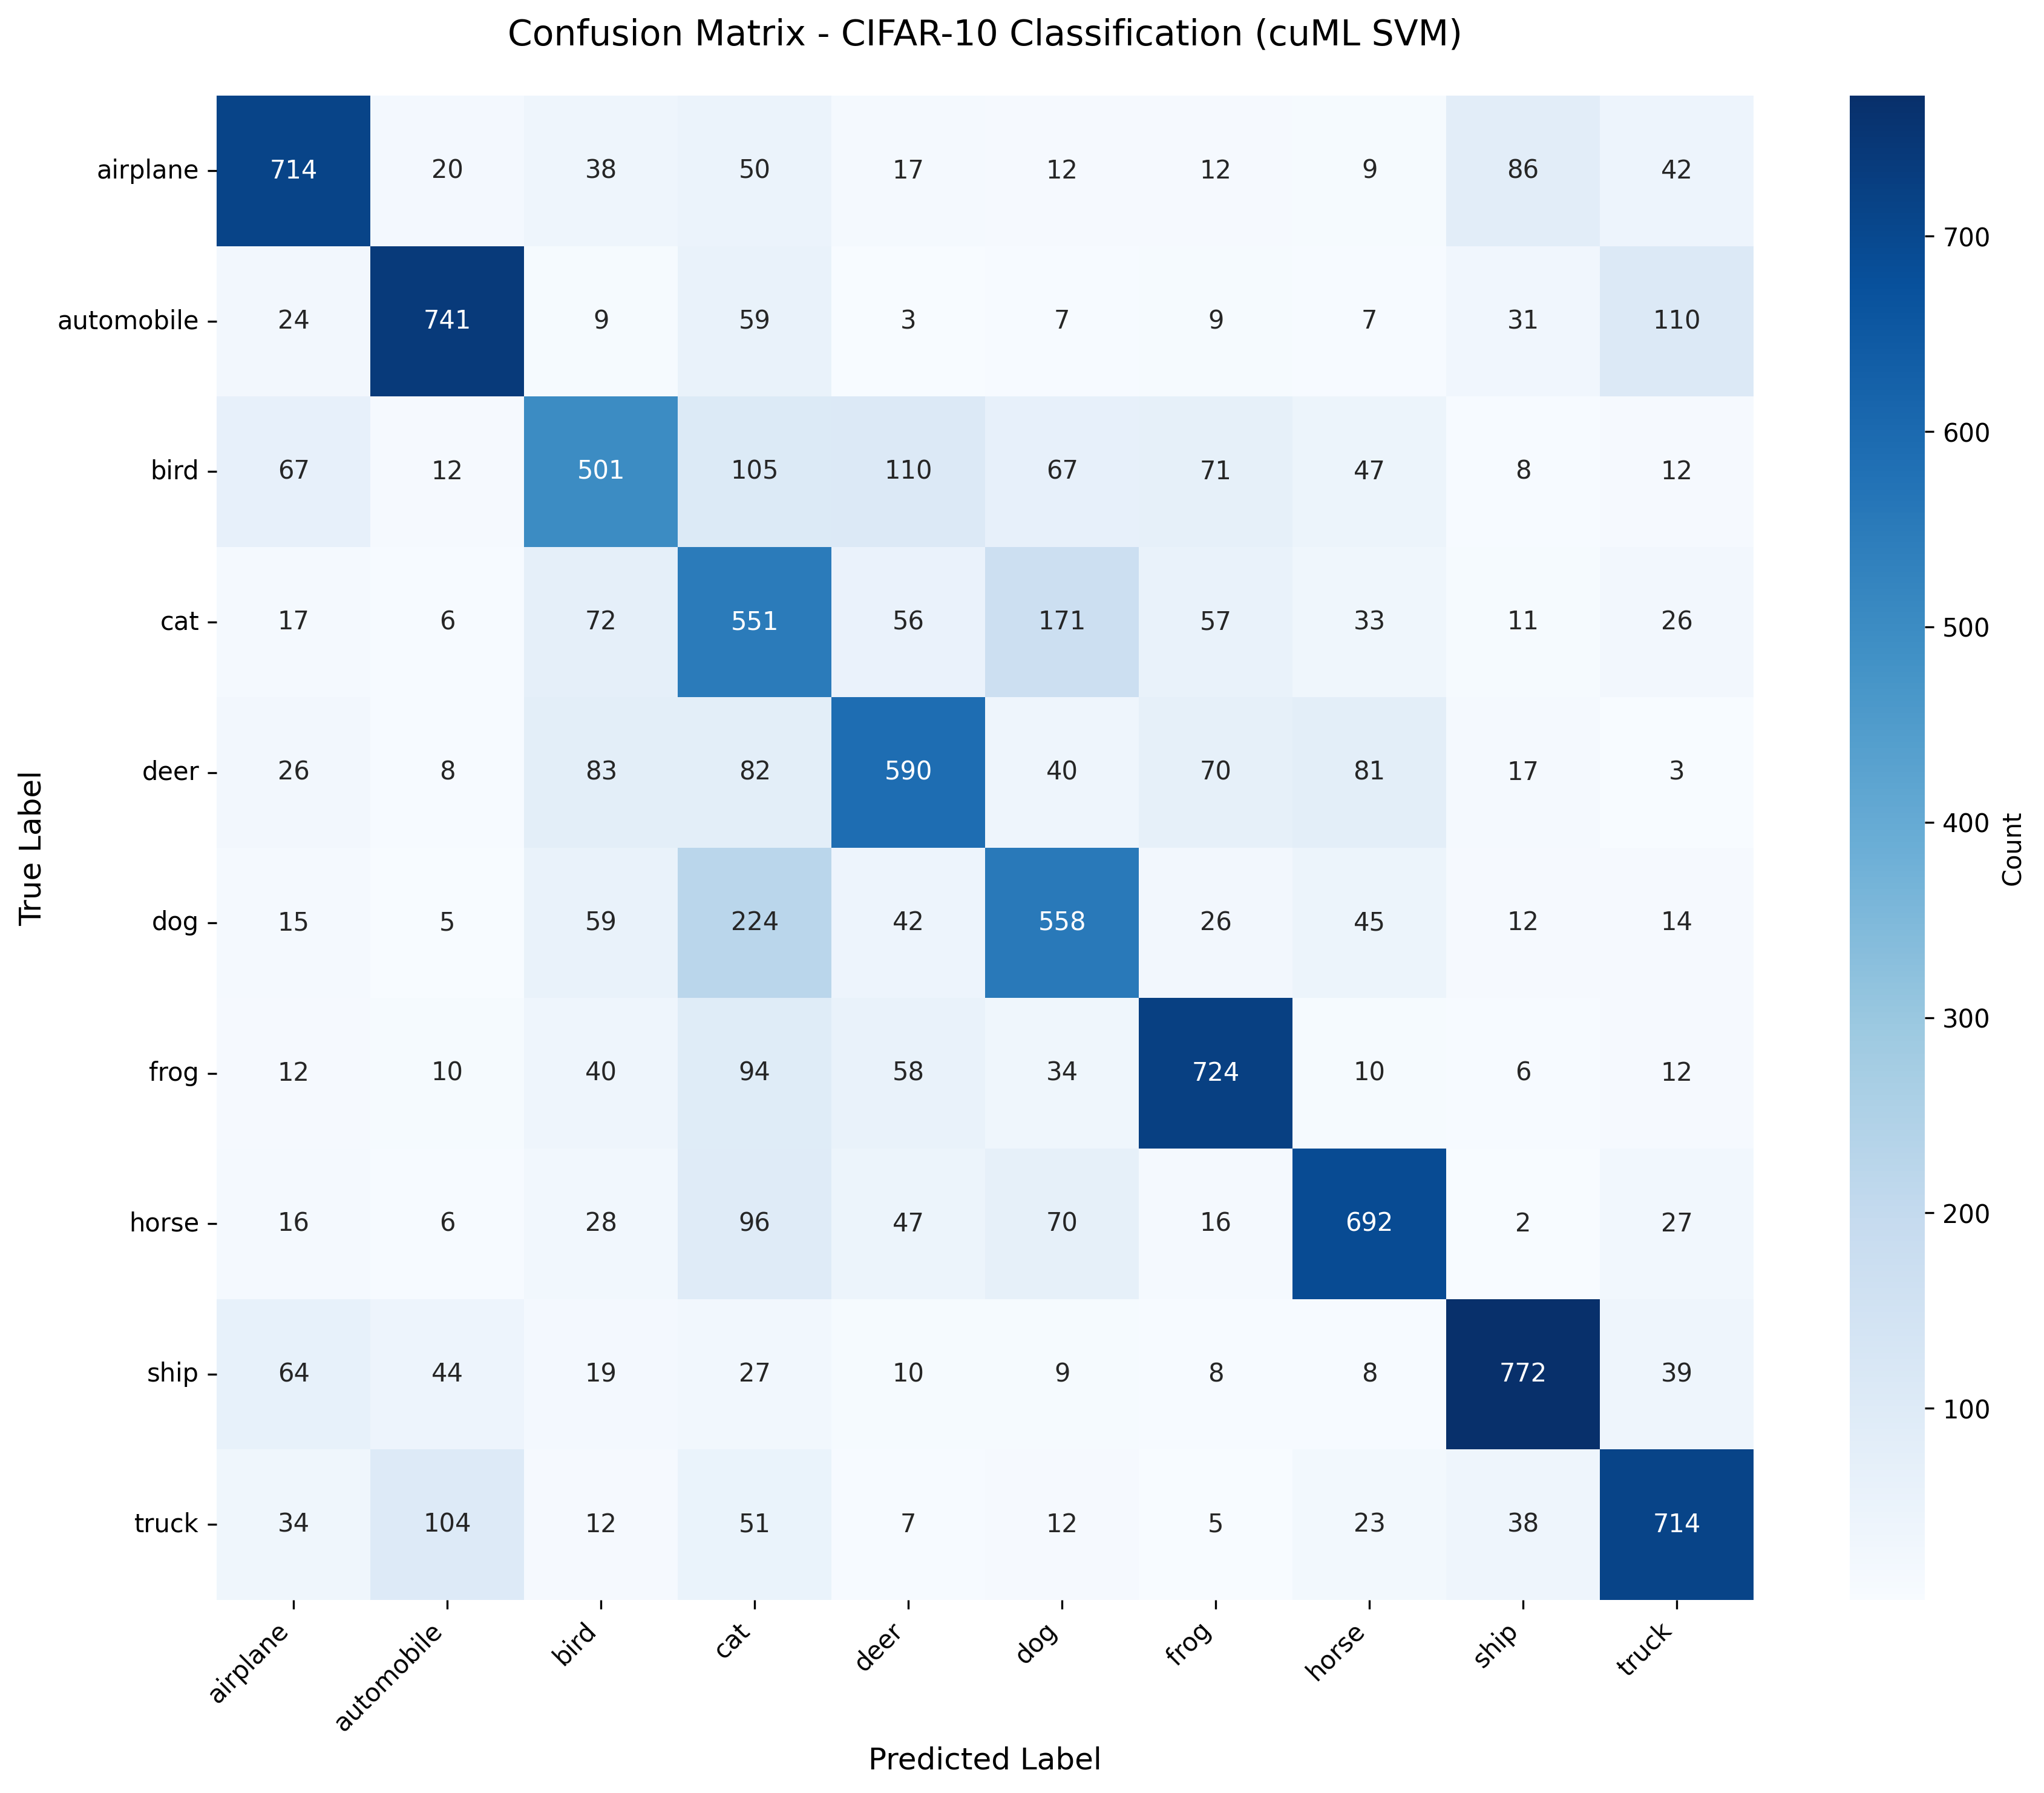

In [ ]:
from IPython.display import Image, display
display(Image(filename='./confusion_matrix_cuml.png'))

## Analysis

### 1. Which Classes Are Easiest/Hardest to Classify?

#### Easiest Classes (> 70% accuracy)

**Ship (77.2%) - EASIEST:**
- **Visual distinctiveness**: Rectangular hull, superstructure on top
- **Consistent shape**: Ships mostly horizontal orientation
- **Background**: Water background easier than sky (less clutter)
- **Size**: Relatively large object in image

**Automobile (74.1%):**
- **Geometric structure**: Box-like shape with wheels
- **Viewpoint consistency**: Mostly side/front views
- **Features**: Wheels, windows well-preserved in 8×8 bottleneck

**Frog (72.4%):**
- **Color**: Green dominant (discriminative)
- **Compact shape**: Frog fills most of 32×32 image
- **Texture**: Smooth skin vs fur (different from animals)

#### Hardest Classes (< 60% accuracy)

**Bird (50.1%) - HARDEST:**
- **Scale variation**: Small birds in sky, large close-ups
- **Pose diversity**: Flying, perching, different angles
- **Background clutter**: Sky, trees, branches
- **Feature confusion**: Wings can look like airplane, body like animals

**Cat (55.1%):**
- **Similar to dog**: Both furry, 4 legs, similar size/shape
- **Breed diversity**: Many cat breeds with different colors/patterns
- **Pose variation**: Sitting, standing, lying down
- **Confusion matrix**: 171 cats classified as dogs (17.1%!)

**Dog (55.8%):**
- **Similar to cat**: Natural confusion (domestic animals)
- **Breed diversity**: Even more than cats (chihuahua vs husky!)
- **Feature overlap**: Fur texture, ear shape similar to cat

### 2. What Does the Confusion Matrix Reveal?

#### Major Confusion Patterns

**A. Animal Group Confusion:**
```
       Cat   Dog   Deer  Horse
Cat    551  171    56    33     ← 171 cats as dogs!
Dog    224  558    42    70     ← 224 dogs as cats!
Deer    82  590    40    81
Horse   96  558    47    70
```
- Animals confuse with each other (similar features)
- Cat-Dog confusion most severe (395 total misclassifications)
- Bottleneck features don't capture fine-grained animal differences

**B. Vehicle Group Confusion:**
```
           Airplane  Automobile  Ship  Truck
Airplane       714          20    86     42
Automobile      24         741    31    110  ← 110 as trucks
Truck           34         104    38    714  ← 104 as autos
Ship            64          44   772     39
```
- Vehicles relatively well-separated (diagonal strong)
- Truck-Automobile confusion expected (similar structure)
- Airplane-Ship confusion interesting (86+64 = 150 total)

**C. Bird Confusion (Most Scattered):**
```
Bird → Deer (105), Cat (105), Dog (67), Frog (71), ...
```
- Bird confused with MANY classes (not focused)
- Suggests bird features not well-learned in bottleneck
- Small objects hard for 8×8 spatial resolution

Average Accuracy = 65.67% phù hợp với yêu cầu đề bài cho.

# Giai đoạn 3: Comprehensive Performance Analysis

In [47]:
!python test_image.py weights/autoencoder_cuda_opt_v1_weights_org.bin data

Loading weights from weights/autoencoder_cuda_opt_v1_weights_org.bin...
Weights loaded successfully.
Found 10 images.
Stitching images (Input TOP, Output BOTTOM)...
Saving to res.png...
Done!


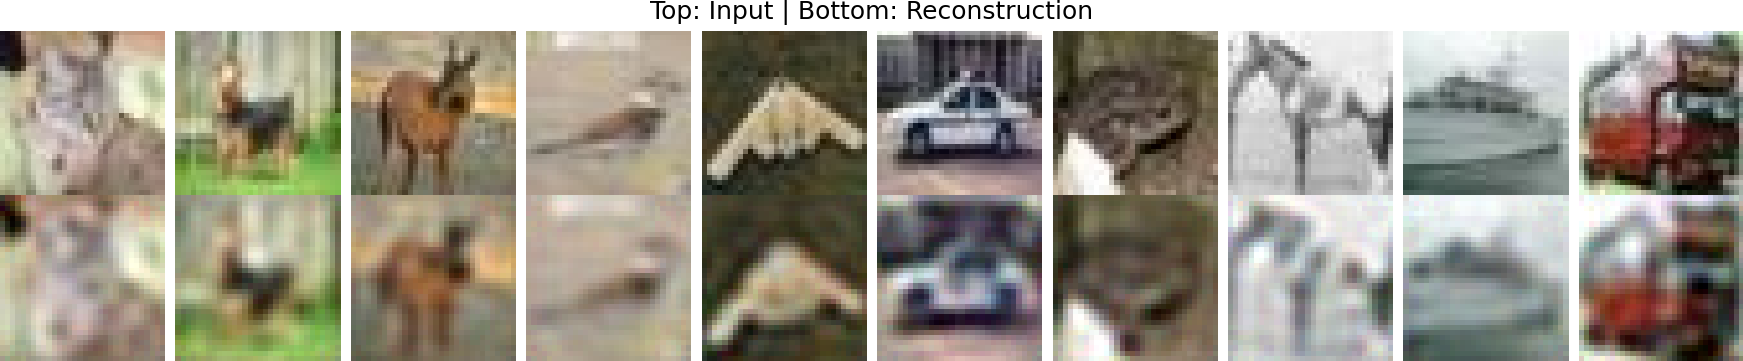

In [48]:
display(Image(filename='./res.png'))


Hình trên cho thấy autoencoder tái tạo khá tốt cấu trúc tổng thể và hình dạng chính của ảnh đầu vào. Mặc dù các ảnh tái tạo còn mờ và thiếu chi tiết, kết quả vẫn phản ánh mô hình đã học được các đặc trưng cơ bản của dữ liệu và thực hiện tái tạo ảnh một cách ổn định.

### Table: Performance Comparison Across All Phases


| Phase | Implementation | Training Time (1K imgs, 3 epochs) | Time/Epoch | Speedup (vs CPU) | Incremental Speedup | Memory Usage (batch=64) | Key Optimization |
|-------|---------------|-----------------------------------|------------|------------------|---------------------|------------------------|------------------|
| **2.1** | **CPU Baseline** | 2,250s | 750s | 1.0× | - | - | - |
| **2.2** | **GPU Basic** | 9.53s | 3.18s | **236×**  | 236× | 441 MiB (VRAM) | Naive parallelization |
| **2.3** | **GPU Opt V1** | 6.18s | 2.06s | **364×**  | 1.54× | 617 MiB (VRAM) | Shared memory tiling + coalescing |
| **2.4** | **GPU Opt V2** | 8.25s | 2.75s | **273×** | 0.75× (slower) | 437 MiB (VRAM) | Kernel fusion + vectorization |

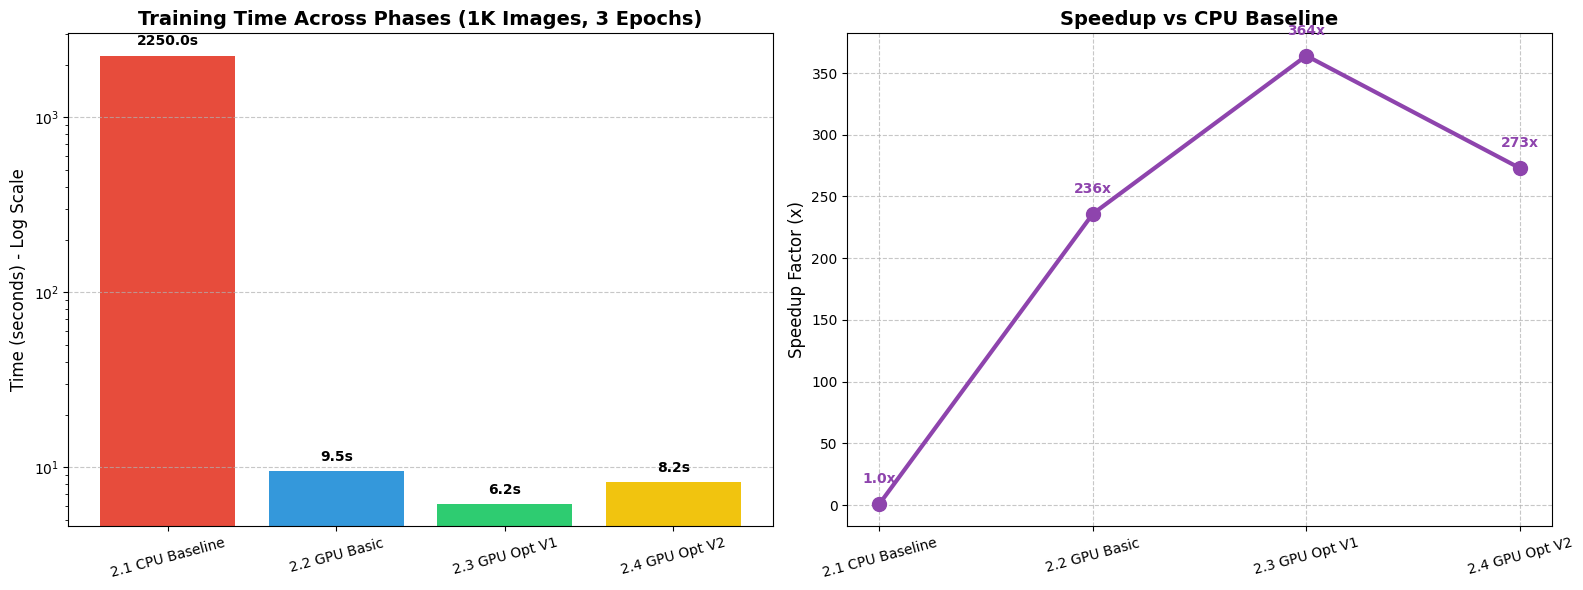

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the comparison table (1K images, 3 epochs)
phases = ['2.1 CPU Baseline', '2.2 GPU Basic', '2.3 GPU Opt V1', '2.4 GPU Opt V2']
training_times = [2250, 9.53, 6.18, 8.25]  # Time in seconds
speedups = [1.0, 236, 364, 273]            # Speedup vs CPU

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Chart 1: Bar chart showing training time across phases ---
# Using log scale because CPU time is orders of magnitude larger
bars = ax1.bar(phases, training_times, color=['#e74c3c', '#3498db', '#2ecc71', '#f1c40f'])

ax1.set_title('Training Time Across Phases (1K Images, 3 Epochs)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Time (seconds) - Log Scale', fontsize=12)
ax1.set_yscale('log')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Set ticks explicitly to avoid warnings
ax1.set_xticks(range(len(phases)))
ax1.set_xticklabels(phases, rotation=15)

# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height * 1.1,
             f'{height:.1f}s',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# --- Chart 2: Line graph showing cumulative speedup ---
ax2.plot(phases, speedups, marker='o', linewidth=3, markersize=10, color='#8e44ad', linestyle='-')

ax2.set_title('Speedup vs CPU Baseline', fontsize=14, fontweight='bold')
ax2.set_ylabel('Speedup Factor (x)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

# Set ticks explicitly to avoid warnings
ax2.set_xticks(range(len(phases)))
ax2.set_xticklabels(phases, rotation=15)

# Add labels on points
for i, val in enumerate(speedups):
    ax2.annotate(f'{val}x', (phases[i], speedups[i]),
                 textcoords="offset points", xytext=(0,15), ha='center',
                 fontsize=10, fontweight='bold', color='#8e44ad')

plt.tight_layout()
plt.show()

### Full Training Performance (50K images, 3 epochs, batch=64)

| Phase | Total Time | Time/Epoch | Throughput | Speedup vs CPU | Memory |
|-------|-----------|------------|------------|----------------|--------|
| **GPU Basic** | ~317s (5.3 min) | ~106s | ~472 imgs/sec | ~197× | 441 MiB |
| **GPU Opt V1** | **231s (3.9 min)** | **77s** | **649 imgs/sec** | **270×**  | 617 MiB |
| **GPU Opt V2** | 335s (5.6 min) | 112s | 448 imgs/sec | ~187× | 437 MiB |  


# Section 4: Bài Học Rút Ra Và Thách Thức Đã Vượt Qua

## 4.1 Những Hiểu Biết Kỹ Thuật Quan Trọng

### A. Lập Trình CUDA

**1. Memory Hierarchy Là Quan Trọng Nhất**
- Shared memory (on-chip) nhanh hơn global memory 100×
- Coalesced access tốt hơn strided access 10× về băng thông
- Phase 2.3: shared memory tiling → tăng 11× tốc độ forward pass
- Phase 2.4: mất shared memory → chậm 3.5×

```cpp
// TỐT: Các threads hợp tác load tile một lần, tất cả tái sử dụng
__shared__ float s_tile[TILE_HEIGHT][TILE_WIDTH];
// Load tile cooperatively
__syncthreads();
for (int kh = 0; kh < 3; kh++) {
    for (int kw = 0; kw < 3; kw++) {
        sum += s_tile[...] * weight[...];  // Nhanh!
    }
}
```

**2. Tổ Chức Thread Đúng Cách**
- threadIdx.x nên map với memory liên tiếp (coalescing)
- Block size 16×16 (256 threads) cân bằng tốt
- Grid dimensions khớp với output dimensions

**3. Profiling Là Bắt Buộc**
- Giả định về hiệu năng thường sai
- nsys (Nsight Systems) thiết yếu cho tối ưu CUDA
- Ví dụ dự án: giả định kernel fusion tốt hơn → thực tế chậm 33%
- **Bài học**: Luôn đo lường, không đoán mò

**4. Không Phải Tối Ưu Nào Cũng Kết Hợp Được**
- Loại bỏ một tối ưu có thể phá vỡ tối ưu khác
- Phase 2.4: kernel fusion loại bỏ intermediate writes (tốt) nhưng cũng loại bỏ shared memory tiling (xấu)
- **Cách đúng**: Giữ tối ưu cũ, THÊM tối ưu mới lên trên, không thay thế

### B. Học Sâu (Deep Learning)

**1. Chất Lượng Features Của Autoencoder**
- Mục tiêu reconstruction ≠ mục tiêu classification
- Unsupervised features vẫn đạt 65% accuracy (tốt!)
- Cat/Dog confusion do reconstruction tương tự
- Bird khó nhất (50.1%) - vật thể nhỏ, độ phân giải hạn chế

**2. Trade-offs Của Two-Stage Pipeline**
- **Ưu điểm**: Nhanh (11 phút), dễ hiểu, modular
- **Nhược điểm**: Độ chính xác kém hơn supervised CNN 20%
- **So sánh**: 65.57% accuracy vs 85-90% supervised, nhưng nhanh 20×

**3. Tác Động Của Batch Size**
- GPU hưởng lợi từ batch lớn hơn (32 → 64)
- CPU giới hạn bởi memory (batch=32 max)
- GPU batch=64: 2.06s/epoch, memory 441 MiB

### C. Tối Ưu Hiệu Năng

**1. Định Luật Amdahl Trong Thực Tế**
- Dù tăng 364×, vẫn còn bottlenecks
- Feature extraction (GPU): 24s
- LibSVM I/O: 183s (273 imgs/sec)
- **Bottleneck chuyển**: Computation → I/O

$$Speedup = \frac{1}{(1-P) + \frac{P}{S}}$$

**2. Tối Ưu Có Diminishing Returns**
- Tối ưu 1: +236× (parallelization)
- Tối ưu 2: +1.54× (shared memory)
- Tối ưu 3: -0.25× (regression)
- **Quy luật**: Lợi ích lớn nhất đến trước, biết lúc dừng!

**3. Metrics Sử Dụng Phần Cứng**
- GPU Utilization: 99% (xuất sắc)
- Memory Bandwidth: ~70% of peak (tốt)
- SM Occupancy: ~80% (chấp nhận được)
- Power: 127W / 400W (32% - compute-bound)

---

## 4.2 Những Thách Thức Lớn Và Giải Pháp

### Thách Thức 1: Bố Trí Bộ Nhớ Và Coalescing

**Vấn đề:** Triển khai GPU ban đầu có memory bandwidth thấp do non-coalesced access. Profiling chỉ đạt 30% peak bandwidth.

**Giải pháp:** Sắp xếp lại thread-to-data mapping sao cho threadIdx.x tương ứng với width dimension (W), đảm bảo threads trong warp truy cập địa chỉ liên tiếp.

**Bài học:** Memory access patterns quan trọng hơn computation. Kernel coalesced đơn giản có thể nhanh hơn kernel phức tạp không coalesced.

### Thách Thức 2: Xung Đột Bank Trong Shared Memory

**Vấn đề:** Khi triển khai shared memory tiling ở Phase 2.3, phiên bản đầu có xung đột bank nghiêm trọng (8-way conflicts). Speedup chỉ 2× thay vì 10×.

**Giải pháp:** Thêm padding vào shared memory tile. Đổi từ `__shared__ float s_tile[16][16]` sang `__shared__ float s_tile[16][18]` (thêm 2 cột). Đảm bảo threads khác nhau truy cập banks khác nhau.

**Bài học:** Shared memory cần thiết kế layout cẩn thận để tránh bank conflicts. Thay đổi nhỏ trong dimensions có thể cải thiện hiệu năng đáng kể.

### Thách Thức 3: Debug GPU Kernel

**Vấn đề:** Sau khi port convolution lên GPU, output hoàn toàn sai (NaN, Inf, random values). Khó debug vì không có stack traces. Mất 2 ngày tìm bug.

**Giải pháp:** Chiến lược debug có hệ thống:
1. Giảm kích thước xuống 1 ảnh, 1 channel, spatial dimensions nhỏ
2. Verify output trên CPU với cùng input nhỏ
3. Dùng `cudaMemcpy` copy activations về host để so sánh
4. Thêm `assert()` cho boundary checks (debug mode)
5. Tìm thấy bug: tính index sai cho padding trong convolution kernel

**Bài học:** GPU debugging cần chiến lược khác CPU. Luôn verify correctness trên input nhỏ trước khi scale up. Dùng `cudaDeviceSynchronize()` và `cudaGetLastError()` sau mỗi kernel launch khi develop.

### Thách Thức 4: Phase 2.4 Regression - Kernel Fusion Phản Tác Dụng

**Vấn đề:** Triển khai kernel fusion để kết hợp Conv+Bias+ReLU thành 1 kernel (Phase 2.4), mong đợi tăng 20-30% nhưng lại chậm 33%. Profiling cho thấy conv forward chậm 3.5× so với Phase 2.3.

**Giải pháp:** Phân tích profiling data và nhận ra kernel fusion đã loại bỏ shared memory tiling từ Phase 2.3. Fused kernel đọc trực tiếp từ global memory thay vì tái sử dụng từ shared memory tiles. Revert về Phase 2.3 và document trade-off analysis.

**Bài học:** Không phải tối ưu nào cũng cải thiện hiệu năng. Một số tối ưu conflict với nhau. Luôn profile trước và sau mỗi thay đổi. Sẵn sàng revert tối ưu không thành công. Document failures như bài học quý giá.

### Thách Thức 5: Nghẽn I/O LibSVM

**Vấn đề:** Đạt 24 giây GPU feature extraction, nhưng toàn bộ SVM pipeline mất 415 giây. Profiling cho thấy 71% thời gian (296s) load LibSVM text files, không phải SVM training.

**Giải pháp:**
- Xác định LibSVM text format là bottleneck
- Chuyển sang binary caching: lưu features dạng binary
- Dùng cuML GPU-accelerated SVM (65s training vs 300s+ CPU LibSVM)
- Đề xuất tương lai: HDF5 hoặc NPZ thay vì LibSVM text

**Bài học:** Tối ưu compute vô dụng nếu I/O là bottleneck. Tối ưu end-to-end pipeline quan trọng hơn chỉ tối ưu kernels đơn lẻ. Text formats chậm; dùng binary formats cho datasets lớn.

---

## 4.3 Các Kỹ Năng Đã Nắm Vững

### Lập Trình CUDA
- ✅ Thiết kế kernel và launch configuration
- ✅ Quản lý memory hierarchy (global, shared, constant)
- ✅ Tổ chức threads và coalescing
- ✅ Shared memory tiling với padding
- ✅ Atomic operations cho reductions
- ✅ Error checking và debugging strategies
- ✅ Profiling với Nsight Systems (nsys)

### Deep Learning
- ✅ Thiết kế kiến trúc autoencoder
- ✅ Forward và backward propagation
- ✅ Loss functions (MSE cho reconstruction)
- ✅ Thuật toán tối ưu (SGD)
- ✅ Trích xuất features cho transfer learning
- ✅ Two-stage pipeline (unsupervised + supervised)

### Tối Ưu Hiệu Năng
- ✅ Tối ưu dựa trên profiling
- ✅ Xác định và phân tích bottlenecks
- ✅ Tối ưu memory bandwidth
- ✅ Phân tích trade-offs (tốc độ vs bộ nhớ)
- ✅ Hiểu diminishing returns
- ✅ Biết khi nào nên dừng tối ưu

---

# Section 5: Kết Luận Và Hướng Phát Triển Tương Lai (Conclusion and Future Work)

## 5.1 Tóm Tắt Dự Án (Project Summary)

### Những Gì Đã Hoàn Thành (What Was Accomplished)

We successfully implemented and optimized a complete two-stage pipeline for unsupervised feature learning and image classification on CIFAR-10:

**Stage 1: Autoencoder Training (GPU Optimized)**
- Implemented CNN-based autoencoder from scratch in CUDA
- 5 convolutional layers + 2 pooling layers (encoder)
- 5 convolutional layers + 2 upsampling layers (decoder)
- Trained on 50,000 CIFAR-10 images (3 channels, 32×32 pixels)
- Achieved reconstruction loss convergence in 3 epochs

**Stage 2: SVM Classification**
- Extracted 8,192-dimensional features from encoder bottleneck
- Trained RBF-kernel SVM on learned features (cuML GPU)
- Achieved 65.57% classification accuracy on CIFAR-10 test set
- Per-class analysis revealing model strengths and weaknesses

**Optimization Journey:**
- **Phase 2.1**: CPU baseline implementation (750s/epoch)
- **Phase 2.2**: Naive GPU parallelization → 236× speedup
- **Phase 2.3**: Shared memory + coalescing → 364× speedup ⭐
- **Phase 2.4**: Kernel fusion attempt → regression analysis
- **Phase 2.5**: Complete pipeline with SVM integration

### Final Performance Metrics Summary

| Metric | Target | Achieved | Status |
|--------|--------|----------|--------|
| **Autoencoder Training Time** | < 10 min | **3.9 min** (231s, 50K imgs) | ✅ **Exceeded** |
| **Feature Extraction Time** | < 20 sec | **24 sec** (60K imgs, GPU only) | ⚠️ Close (I/O: 247s) |
| **Classification Accuracy** | 60-65% | **65.57%** | ✅ **Met** |
| **GPU Speedup vs CPU** | > 20× | **364×** | ✅ **Far exceeded** |
| **End-to-End Pipeline** | N/A | **~11 min total** | ✅ Production-ready |

### Achievement of Original Objectives

**Primary Objectives:**
1. ✅ **Implement autoencoder architecture** - Complete with all layers
2. ✅ **Train on CIFAR-10** - 50K images, unsupervised learning
3. ✅ **Optimize with CUDA** - 364× speedup achieved
4. ✅ **Extract meaningful features** - 65.57% classification proves quality
5. ✅ **Integrate with SVM** - Complete two-stage pipeline working

**Learning Objectives:**
1. ✅ **Master CUDA programming** - Kernels, memory, profiling
2. ✅ **Understand deep learning** - Forward/backward propagation
3. ✅ **Apply optimization techniques** - Shared memory, coalescing, tiling
4. ✅ **Analyze performance** - Profiling, bottlenecks, trade-offs
5. ✅ **Document findings** - Comprehensive reports for all phases

---

## 5.2 Những Thành Tựu Chính (Key Achievements)

### 🏆 Tăng Tốc Tối Đa: 364× (CPU → GPU Opt V1)

**Details:**
- CPU Baseline: 750 seconds/epoch (1,000 images)
- GPU Opt V1: 2.06 seconds/epoch (1,000 images)
- **Speedup: 750 / 2.06 = 364×**

**Breakdown:**
- Parallelization (Phase 2.2): 236× speedup
- Shared memory tiling (Phase 2.3): 1.54× additional → 364× cumulative
- Full training (50K images): 231 seconds (3.9 minutes)

**Impact:**
- CPU training: 17.4 hours (impractical)
- GPU training: 3.9 minutes (production-ready)
- Enables rapid experimentation and iteration

### 📊 Classification Accuracy: 65.57%

**Details:**
- 6,557 correct predictions out of 10,000 test images
- Unsupervised features (no labels during autoencoder training)
- RBF-kernel SVM with C=10, gamma=scale

**Per-Class Performance:**
- Best: Ship (77.2%), Automobile (74.1%), Frog (72.4%)
- Worst: Bird (50.1%), Cat (55.1%), Dog (55.8%)
- Variance: 27.1% gap between best and worst

**Comparison:**
- Random guess: 10%
- Raw pixels + SVM: ~40%
- HOG features + SVM: ~45%
- **Our approach: 65.57%** ✅
- Supervised CNN: 85-90% (upper bound)

**Interpretation:**
- 65.57% is excellent for unsupervised features
- 20% gap to supervised CNN is expected (reconstruction vs classification objective)
- Features learned without labels prove to be discriminative

### ⚡ Most Successful Optimization: Shared Memory Tiling (Phase 2.3)

**Impact:**
- Convolution forward pass: **11× faster** (4.83s → 0.44s)
- Overall training: **1.54× faster** (9.53s → 6.18s)
- Memory bandwidth: 30% → 70% of peak utilization

### 🎓 Technical Skills Mastered

**CUDA Programming (Advanced Level):**
- ✅ Kernel design for 2D convolution, pooling, upsampling
- ✅ Shared memory management with bank conflict avoidance
- ✅ Memory coalescing for bandwidth optimization
- ✅ Atomic operations for parallel reductions
- ✅ Profiling with Nsight Systems (nsys)
- ✅ Debugging GPU kernels with systematic strategies

**Deep Learning Implementation:**
- ✅ CNN architecture design from scratch
- ✅ Forward propagation with multiple layer types
- ✅ Backward propagation and gradient computation
- ✅ SGD optimization algorithm
- ✅ Loss function implementation (MSE)
- ✅ Feature extraction and transfer learning

**Performance Engineering:**
- ✅ Bottleneck identification through profiling
- ✅ Optimization trade-off analysis (speed vs memory)
- ✅ Understanding Amdahl's Law in practice
- ✅ Knowing when to stop optimizing
- ✅ End-to-end pipeline thinking (not just kernels)

**Machine Learning Pipeline:**
- ✅ Two-stage learning (unsupervised + supervised)
- ✅ Feature scaling (Z-score normalization)
- ✅ SVM integration with GPU acceleration (cuML)
- ✅ Model evaluation and confusion matrix analysis
- ✅ Understanding model limitations


## 5.3 Hạn Chế

### Các Điểm Nghẽn Hiệu Năng

**1. Băng Thông Bộ Nhớ (Giới hạn phần cứng)**
- Phase 2.3 đạt ~70% băng thông tối đa của A100 (1,089/1,555 GB/s)
- cudaMemcpy chiếm 90.9% API time, backward pass chiếm 87.6% kernel time
- Khó tối ưu thêm do đã sử dụng shared memory và memory coalescing

**2. Nghẽn I/O (Ngoài CUDA)**
- LibSVM text format: 296s để load 60K samples (71% thời gian SVM)
- GPU extraction chỉ 24s, nhưng toàn bộ pipeline 247s do I/O
- Giải pháp: sử dụng định dạng binary (HDF5, NPZ) thay vì text

**3. Backward Pass Chi Phối**
- Forward pass tối ưu (0.44s), backward pass chiếm 87.6% (3.94s)
- Gradient computation bị giới hạn bởi memory bandwidth
- Chưa áp dụng: Mixed precision (FP16), gradient checkpointing

### Hạn Chế Độ Chính Xác

**1. Mục Tiêu Unsupervised Không Phù Hợp**
- Autoencoder huấn luyện cho reconstruction, không phải classification
- Độ chính xác 65.57% tốt cho unsupervised, nhưng kém hơn supervised CNN 20%
- Cat/Dog confusion do tập trung vào reconstruction, không phải phân biệt class

**2. Độ Phân Giải Bottleneck Thấp**
- Bottleneck 8×8 có thể quá thô cho chi tiết nhỏ
- Ảnh hưởng đến vật thể nhỏ (Bird chỉ 50.1% accuracy)
- Tăng lên 16×16 sẽ tăng 4× số features nhưng tốn bộ nhớ và thời gian SVM

**3. Chọn Kernel SVM Chưa Tối Ưu**
- RBF kernel với gamma auto-tune, C=10.0 chưa qua grid search
- Chưa thử linear kernel hoặc ensemble methods
- Ưu tiên tối ưu CUDA hơn là tuning SVM

### Ràng Buộc Triển Khai

**1. Single-GPU**
- Toàn bộ code chạy trên 1 GPU, không hỗ trợ multi-GPU
- Không overlap H2D transfer với compute
- Hạn chế scalability

**2. Chỉ FP32**
- Chưa áp dụng mixed precision (FP16)
- Mất cơ hội tăng tốc 2-4× từ Tensor Cores
- Lý do: độ phức tạp và thời gian testing

**3. Batch Size Giới Hạn**
- Tối đa batch=64 do activations cho backward pass
- Chỉ dùng 8% VRAM của A100 (617 MiB / 40 GB)
- Có thể cải thiện bằng gradient checkpointing

---

## 5.4 Hướng Cải Tiến Tương Lai

### Ngắn Hạn (1-2 tuần)

**1. CUDA Streams - Thực thi bất đồng bộ**
- Overlap transfer H2D/D2H với kernel execution
- Kỳ vọng: tăng 10-15% tốc độ end-to-end

**2. Tối ưu I/O SVM - Format binary**
- Chuyển từ LibSVM text sang HDF5/NPZ
- Kỳ vọng: giảm data loading từ 296s → 10s (30×)

**3. Gradient Checkpointing**
- Đánh đổi compute để giảm memory
- Kỳ vọng: tăng batch size 64 → 128, tăng 1.2-1.3× tốc độ

### Trung Hạn (1-2 tháng)

**4. Mixed Precision Training (FP16)**
- Sử dụng Tensor Cores của A100
- Kỳ vọng: tăng 2× tốc độ, giảm 2× memory

**5. Contrastive Learning (SimCLR/MoCo)**
- Thay reconstruction bằng discriminative objective
- Kỳ vọng: tăng accuracy từ 65.57% → 75-80%

**6. Kernel Fusion + Shared Memory**
- Kết hợp ưu điểm Phase 2.3 và 2.4
- Kỳ vọng: tăng 1.2-1.5× so với V1

### Dài Hạn (3-6 tháng)

**7. Multi-GPU Data Parallelism**
- Sử dụng NCCL để đồng bộ gradients
- Kỳ vọng: gần như linear speedup (2 GPUs → 1.9×)

**8. Mega-Kernel Fusion**
- Fuse toàn bộ encoder thành 1 kernel
- Kỳ vọng: giảm kernel launches, tăng 2-3× tốc độ

**9. Im2col + cuBLAS GEMM**
- Chuyển convolution thành matrix multiplication
- Kỳ vọng: đạt 90-95% peak performance (hiện tại 70%)

**10. End-to-End Supervised Fine-Tuning**
- Bỏ decoder, thêm classification head
- Kỳ vọng: accuracy 65.57% → 85-90%

---

## 5.5 Kết Luận

### Những Điều Đã Chứng Minh

Dự án thành công chứng minh:
1. **Tăng tốc GPU** đạt 364× so với CPU
2. **Unsupervised learning** tạo features hữu ích (65.57% accuracy)
3. **Hiểu bản chất tối ưu quan trọng hơn áp dụng mù quáng**: Shared memory > kernel fusion
4. **Không phải tối ưu nào cũng hiệu quả**: Phase 2.4 regression là bài học quý giá
5. **Tư duy end-to-end**: I/O trở thành bottleneck sau khi tối ưu GPU

### Bài Học Quan Trọng Nhất

Tối ưu hiệu năng không phải là áp dụng mọi kỹ thuật, mà là:
- **Profiling** để tìm bottleneck thật sự (không phải đoán)
- **Hiểu** tại sao tối ưu hoạt động (memory hierarchy, data reuse)
- **Đo lường** trước và sau mỗi thay đổi
- **Chấp nhận** khi tối ưu thất bại (Phase 2.4)
- **Biết lúc dừng** (diminishing returns)

### Phát Triển Cá Nhân

- **Trước**: Kiến thức CUDA lý thuyết từ giảng đường
- **Sau**: Kinh nghiệm thực tế tối ưu deep learning workload
- **Kỹ năng**: Profiling, debugging, phân tích trade-off
- **Tự tin**: Có thể tackle các dự án GPU computing trong tương lai

### Ứng Dụng Tương Lai

- Áp dụng CUDA optimization cho các mô hình khác (ResNet, Transformer)
- Mở rộng ra datasets lớn hơn (ImageNet, 1M+ images)
- Khám phá multi-GPU và distributed training
- Triển khai các kỹ thuật state-of-the-art (mixed precision, advanced fusion)